## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [328]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)



## Second, Calculate distortion coefficients, and test undistortion on an image...

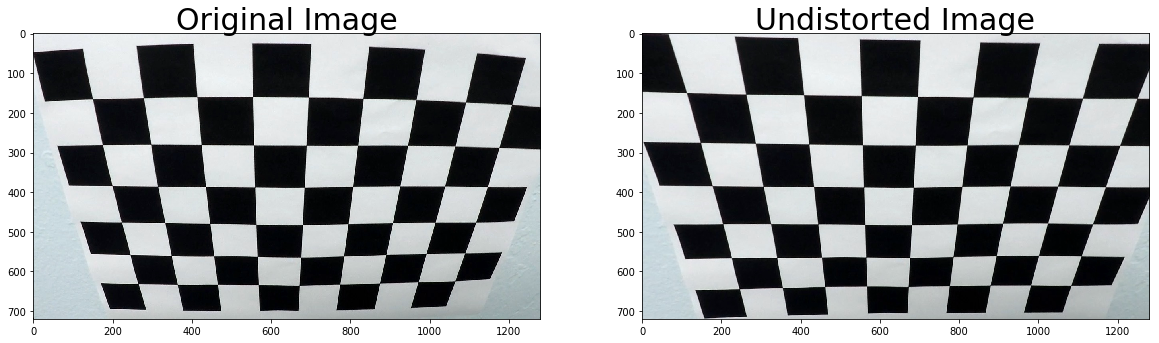

In [327]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
image_shape = img.shape
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
undist_warped = cv2.undistort(img, mtx, dist_coeffs, None, mtx)

cv2.imwrite('output_images/calibration2_undist.jpg',undist_warped)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_warped)
ax2.set_title('Undistorted Image', fontsize=30)


## Third, Color and Gradient thresholding

### Color thresholding (S channel in HLS color space)
  This does a fairly robust job of picking up the lines under very different color and contrast conditions.
  It is especially good in picking up the yellow lanes
  
  
### Graident thresholding 
  This uses sobel operation to detect the edges after converting the color image to the gray image first.
  Sobel X gradient operations is good at picking up lines close to the vertical line.

In [274]:
# hls_select: apply S channel threshold in HLS color space
def apply_color_thresh(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    hls_s = hls[:,:,2]
    bin_mask = np.zeros_like(hls_s)
    bin_mask[(hls_s > thresh[0]) & (hls_s <= thresh[1])] = 1
       
    # 3) Return a binary image of threshold result
    return bin_mask
    

def apply_gradient_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    sobel_gradient = cv2.Sobel(gray, cv2.CV_64F, (orient=='x'), (orient!='x'))
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.abs(sobel_gradient)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(abs_sobel*255 / np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude 
    bin_mask = np.zeros_like(scaled_sobel)
    bin_mask[(scaled_sobel >= thresh_min) & (scaled_sobel < thresh_max )] = 1
    
    # 6) Return this mask as your binary_output image
    return bin_mask


def apply_dir_thresh(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    bin_mask = np.zeros_like(direction)
    bin_mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return bin_mask


def apply_lane_threshold(image):      
    # apply S (in HLS color space) channel threshold min, max
    color_thresh = (170, 255)    
    color_bin = apply_color_thresh(image, color_thresh)
    
    # convert the color image to grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Sobel gradient operation threshold min, max 
    gradient_thresh = (20, 100) 
    # Sobel operation direction ('x', 'y')
    sobel_orient = 'x'
    # apply sobel gradient thresholding to detect the edges
    gradient_bin = apply_gradient_thresh(gray, sobel_orient, gradient_thresh[0], gradient_thresh[1])
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_bin = apply_dir_thresh(gray, thresh=(np.pi/6, np.pi/2))

    # combined condition of sober gradient and direction threshold
    combined_condition = ((gradient_bin == 1) & (dir_bin == 1))
    
    # color and gradient thresholds combined
    thresholded_bin = np.zeros_like(color_bin)
    thresholded_bin[(color_bin == 1) | (combined_condition == 1)] = 1

    # additional masking out 
    #mask = np.zeros_like(color_bin)
    #mask[300:720,170:1100,] = 1
    #thresholded_bin = thresholded_bin & mask
    
    return thresholded_bin


### Color/Gradient Thresholding Verification (1) 

921600


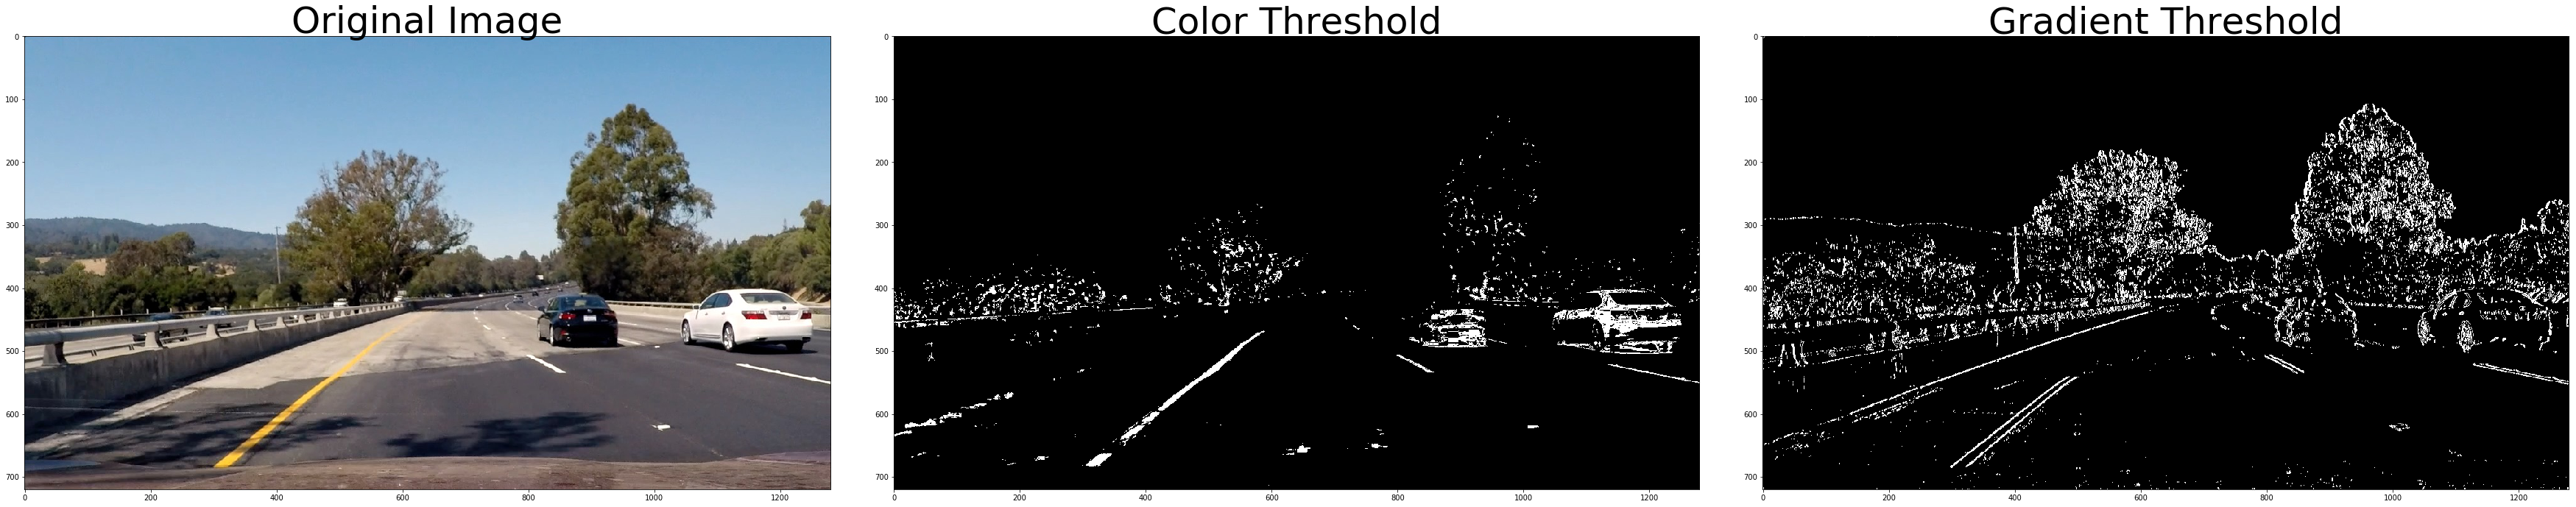

In [326]:
INPUT_IMAGE1 = 'test_images/test4.jpg'

#image = mpimg.imread('test_images/straight_lines1.jpg')
image = mpimg.imread(INPUT_IMAGE1)
    
# tune the threshold to try to match the above image!    
color_bin = apply_color_thresh(image, thresh=(170, 255))
print(color_bin.size)

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gradient_bin = apply_gradient_thresh(gray, orient='x', thresh_min=20, thresh_max=100)

# save the output images as files
mpimg.imsave('output_images/color_threshold.jpg', color_bin, format='jpg', cmap='gray')
mpimg.imsave('output_images/gradient_threshold.jpg', gradient_bin, format='jpg', cmap='gray')

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(color_bin, cmap='gray')
ax2.set_title('Color Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax3.imshow(gradient_bin, cmap='gray')
ax3.set_title('Gradient Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=2, top=0.9, bottom=0.)

### Color/Gradient Combined Thresholding Verification (2) 

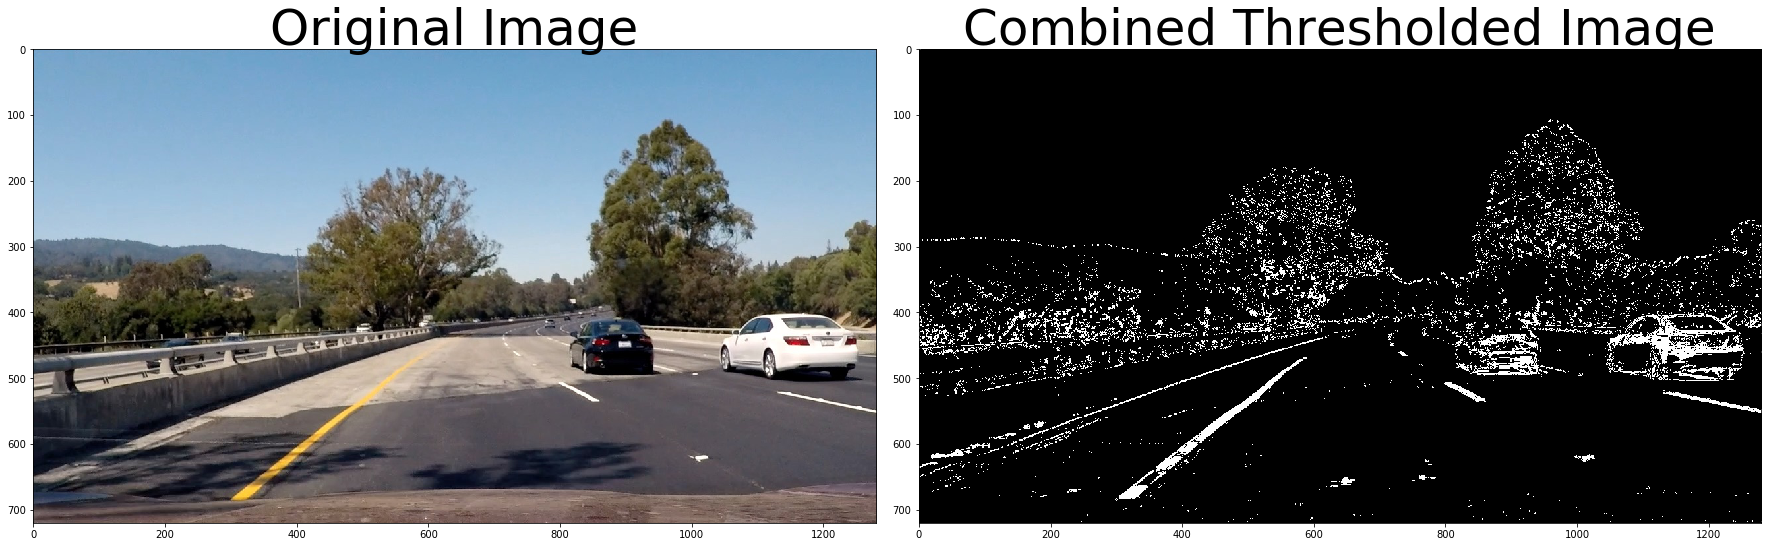

In [320]:
#test_image = mpimg.imread('test_images/straight_lines1.jpg')
test_image = mpimg.imread(INPUT_IMAGE)

# apply color (HLS-S color channel), sobel gradient & directional thresholding
test_thresh_bin = apply_lane_threshold(test_image)
test_color_binary = np.dstack((test_thresh_bin, test_thresh_bin, test_thresh_bin)) * 255

#plt.imshow(test_thresh_bin, cmap='gray')

# display the original and warped images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_color_binary, cmap='gray')
ax2.set_title('Combined Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# save the output as a file
mpimg.imsave('output_images/combined_threshold.jpg', test_color_binary, format='jpg')

## Fourth, Perspective transform from binary image to "birds-eye view"

The easiest way to do this is to investigate a test image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective. 

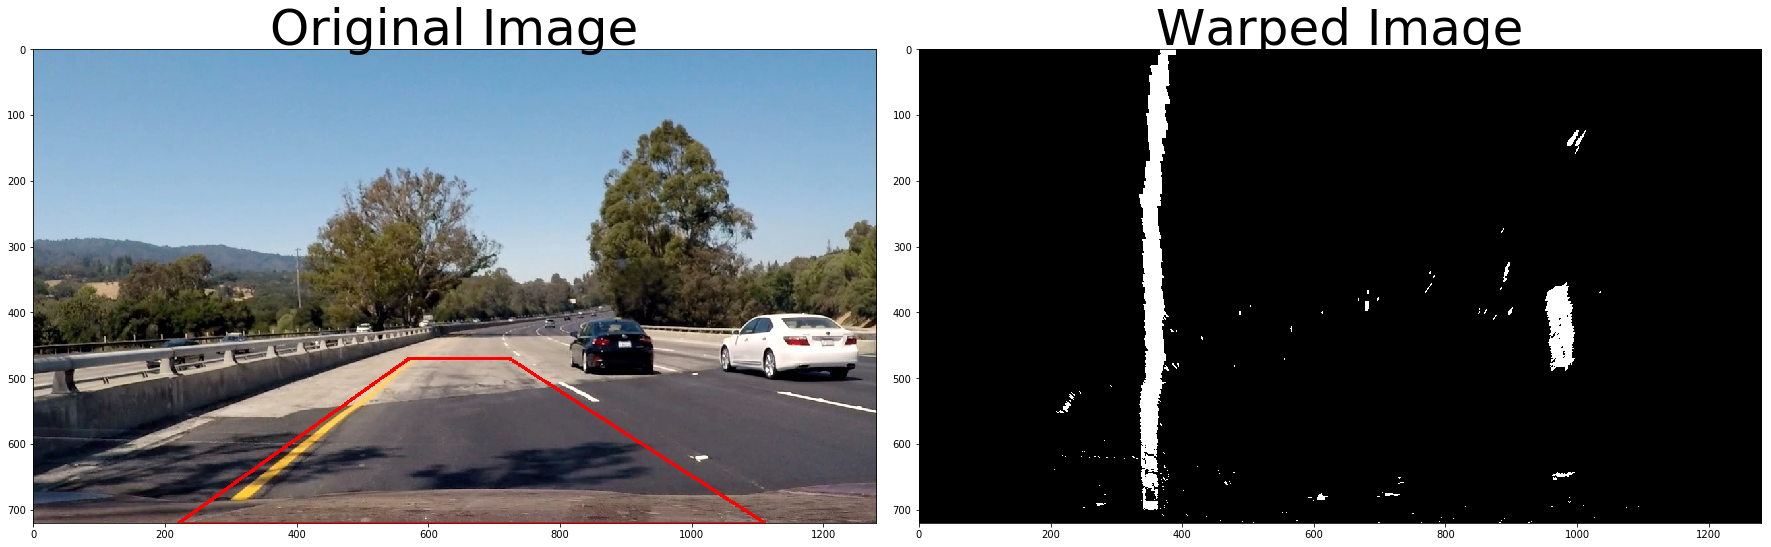

In [325]:
image_shape = test_image.shape

# Source points extracted manually for performing a perspective transform
bottom_left = [220,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]
source = np.float32([bottom_left,bottom_right,top_right,top_left])

# Draw poly lines of the source points
pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
img_copy = test_image.copy()
cv2.polylines(img_copy,[pts],True,(255,0,0), thickness=3)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

destination = np.float32([bottom_left,bottom_right,top_right,top_left])

# Get the perspective matrix by passing source and destination points
perspective_M = cv2.getPerspectiveTransform(source, destination)
# Get the inverse perspective matrix 
perspective_M_inv = cv2.getPerspectiveTransform(destination, source)

# Get the bird-view (warped) image by doing the perspective transformation from the test image (thresholded)
img_size = (image_shape[1], image_shape[0])
test_warped = cv2.warpPerspective(test_thresh_bin, perspective_M, img_size, flags=cv2.INTER_LINEAR)

# mask out outside lane lines
mask = np.zeros_like(test_warped)
mask[:,200:1100,] = 1
test_warped = test_warped & mask
    
# Save the warped test image
warped_color = np.dstack((test_warped, test_warped, test_warped)) * 255
cv2.imwrite('output_images/input_image1_warped.jpg',warped_color)

# display the original and warped images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Run pipeline on all the test images for line detection

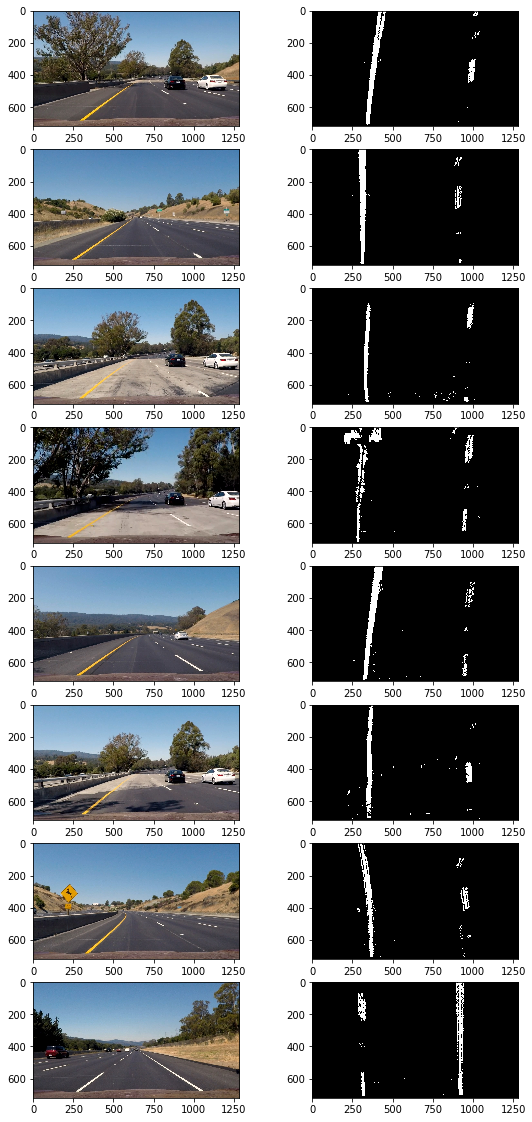

In [279]:
def pipeline(test_image):
    # Undistort
    undist = cv2.undistort(test_image, mtx, dist_coeffs, None, mtx)
    
    # apply color (HLS-S color channel), sobel gradient & directional thresholding
    thresholded_bin = apply_lane_threshold(undist)
    
    # Perspective Transform
    image_shape = test_image.shape
    img_size = (image_shape[1], image_shape[0])
    img_warped = cv2.warpPerspective(thresholded_bin, perspective_M, img_size, flags=cv2.INTER_LINEAR)

    # mask out outside lane lines
    mask = np.zeros_like(img_warped)
    mask[:,200:1100,] = 1
    img_warped = img_warped & mask
    
    #color_binary = np.dstack((img_warped, img_warped, img_warped)) * 255

    return img_warped


# Pipeline test on all test images provided
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    out_image = pipeline(img)
    axs[i].imshow(img)
    i += 1
    axs[i].imshow(out_image, cmap='gray')
    i += 1

## Fifth, Locate the Lane Lines (Histogram & Slide Window)

### Histogram

After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. 
The next step is to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

Plotting a histogram of where the binary activations occur across the image is one potential solution for this.

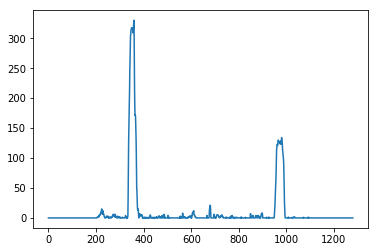

In [281]:
def histogram(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
hist = histogram(test_warped)

# Visualize the resulting histogram
plt.plot(hist)


### Line class

Line class has been defined to encapsulate the line extraction functionality from the warped image. 

In [282]:
class Line(): 
    def __init__(self):
        self.left_fit = np.array([])
        self.right_fit = np.array([])
               
        self.left_fitx = np.array([])
        self.right_fitx = np.array([])
        self.ploty = np.array([])
        
        self.leftx = np.array([])
        self.rightx = np.array([])
        self.lefty = np.array([])
        self.righty = np.array([])
        
        #radius of curvature of the line and distance from the center
        self.left_curverad = None
        self.right_curverad = None
        self.center_dist = None
        
        # TODO - not being used yet
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]

        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
        
        
    def slide_window_polyfit(self, warped, draw = 1):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result

        warped_clr_img = np.dstack((warped, warped, warped))

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 10
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped.shape[0] - (window+1)*window_height
            win_y_high = warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            if (draw == 1):
                cv2.rectangle(warped_clr_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
                cv2.rectangle(warped_clr_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        self.fit_poly(warped.shape, self.leftx, self.lefty, self.rightx, self.righty)
        
        return warped_clr_img

    
    def search_around_polyfit(self, binary_warped, draw=1):
        # HYPERPARAMETER
        # width of the margin around the previous polynomial to search
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
                        self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
                        self.left_fit[1]*nonzeroy + self.left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
                        self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
                        self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        self.fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        warped_clr_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(warped_clr_img)
        # Color in left and right line pixels
        warped_clr_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        warped_clr_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx-margin, self.ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+margin, 
                                  self.ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([self.right_fitx-margin, self.ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx+margin, 
                                  self.ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(warped_clr_img, 1, window_img, 0.3, 0)

        if (draw == 1):
            # Plot the polynomial lines onto the image
            plt.plot(self.left_fitx, self.ploty, color='yellow')
            plt.plot(self.right_fitx, self.ploty, color='yellow')
            ## End visualization steps ##
        
        return result


    def fit_poly(self, img_shape, leftx, lefty, rightx, righty):
        ### Fit a second order polynomial to each with np.polyfit() ###
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### Calc both polynomials using ploty, left_fit and right_fit ###
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

    
    def do_polyfit_image(self, warped, draw=1):
        # Find our lane pixels first
        out_img = self.slide_window_polyfit(warped, draw)

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[self.lefty, self.leftx] = [255, 0, 0]
        out_img[self.righty, self.rightx] = [0, 0, 255]

        return out_img

    
    def measure_curvature_center_dist(self, warped):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty)

        self.left_curverad = ((1 + (2*self.left_fit[0]*y_eval*ym_per_pix + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        self.right_curverad = ((1 + (2*self.right_fit[0]*y_eval*ym_per_pix + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])

        h = warped.shape[0]
        
        # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
        car_pos = warped.shape[1]/2
        l_fit_x_int = self.left_fit[0]*h**2 + self.left_fit[1]*h + self.left_fit[2]
        r_fit_x_int = self.right_fit[0]*h**2 + self.right_fit[1]*h + self.right_fit[2]
               
        lane_center_pos = (r_fit_x_int + l_fit_x_int) /2
        self.center_dist = (car_pos - lane_center_pos) * xm_per_pix

        return self.left_curverad, self.right_curverad, self.center_dist

    
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


### Finding the Lines: Slide Window

We can use the two highest peaks from the histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.

1. Split the histogram for the two lines
2. Set up windows and window hyperparameters
3. Iterate through nwindows to track curvature
4. Fit a polynomial
5. Visualization

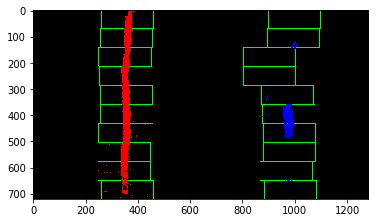

In [324]:
# Test the polynomial fit from the test image and draw the sliding window and fit
#out_img = fit_poly_image(test_warped)

line_obj1 = Line()
test1_out_img = line_obj1.do_polyfit_image(test_warped)

plt.imshow(test1_out_img)
#cv2.imwrite('examples/straight_lines1_polynomial.jpg',test1_out_img)
mpimg.imsave('output_images/input_image1_slide_window.jpg',test1_out_img, format='jpg')

## Finding the Lines: Search from Prior

#### Skip the sliding windows step once you've found the lines

Using the full algorithm from before and starting fresh on every frame may seem inefficient, as the lane lines don't necessarily move a lot from frame to frame.
In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous lane line position, like in the above image. The green shaded area shows where we searched for the lines this time. So, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame. 

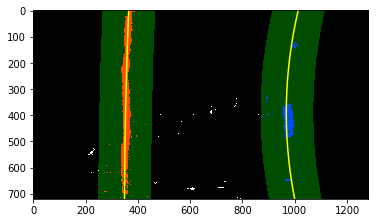

In [323]:
INPUT_IMAGE2 = 'test_images/test3.jpg'

lineobj = Line()
test1_out = lineobj.do_polyfit_image(test_warped, draw=1)


# Run image through the pipeline
# Load our image - this should be a new frame since last time!
test2_image = mpimg.imread(INPUT_IMAGE2)

# apply color (HLS-S color channel), sobel gradient & directional thresholding
test2_threshed = apply_lane_threshold(test2_image)
#test_color_binary = np.dstack((test_thresh_bin, test_thresh_bin, test_thresh_bin)) * 255

img_size = (test2_threshed.shape[1], test2_threshed.shape[0])
test2_warped = cv2.warpPerspective(test2_threshed, perspective_M, img_size, flags=cv2.INTER_LINEAR)

# Note that in your project, you'll also want to feed in the previous fits
test2_out = lineobj.search_around_polyfit(test_warped)

# View your output
plt.imshow(test2_out)
mpimg.imsave('output_images/input_image2_search_from_prior.jpg',test2_out, format='jpg')

## Determine the curvature of the lane and vehicle position with respect to center

In [127]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
rad_l, rad_r, d_center = lineobj.measure_curvature_center_dist(test_warped)

print(rad_l, rad_r, d_center)


21303.1280991 1804.81914912 -0.18074936036


## Draw the detected lanes on the original image

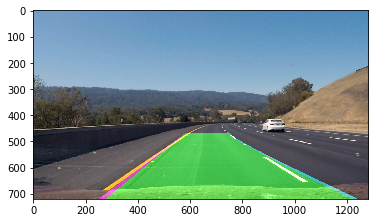

In [292]:
def draw_lane(org_img, bin_img, line, Minv):
    new_img = np.copy(org_img)
    if line.left_fit is None or line.right_fit is None:
        return original_img
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([line.left_fitx, line.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([line.right_fitx, line.ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h,w = bin_img.shape
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
    

lane_overlay = draw_lane(test2_image, test_warped, lineobj, perspective_M_inv)
plt.imshow(lane_overlay)

# save the output to a file
mpimg.imsave('output_images/draw_lane.jpg', lane_overlay, format='jpg')


## Pipeline Test 

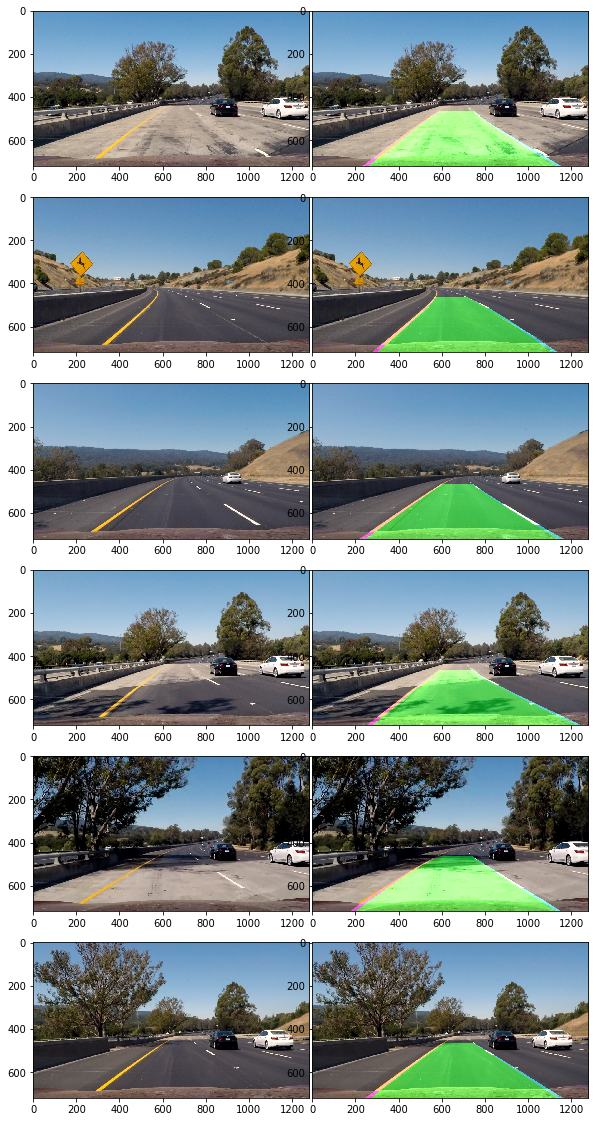

In [134]:
pip_testimg = cv2.imread('./test_images/test1.jpg')
pip_testimg = cv2.cvtColor(pip_testimg, cv2.COLOR_BGR2RGB)
pip_warped_image = pipeline(pip_testimg) 

pip_line_obj = Line()
pip_out_img = pip_line_obj.do_polyfit_image(pip_warped_image, draw=0)

lane_overlay = draw_lane(pip_testimg, pip_warped_image, pip_line_obj, perspective_M_inv)
#plt.imshow(lane_overlay)

# Make a list of example images
test_images = ['./test_images/test2.jpg','./test_images/test3.jpg','./test_images/test4.jpg','./test_images/test5.jpg','./test_images/test6.jpg']
                                          
# Set up plot
fig, axs = plt.subplots(len(images)+1, 2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0    
axs[i].imshow(pip_testimg)
i += 1
axs[i].imshow(lane_overlay)
i += 1
    
for image in test_images:
    pip_testimg = cv2.imread(image)
    pip_testimg = cv2.cvtColor(pip_testimg, cv2.COLOR_BGR2RGB)
    pip_warped_image = pipeline(pip_testimg) 
    pip_out_img = pip_line_obj.search_around_polyfit(pip_warped_image, draw=0)
    lane_overlay = draw_lane(pip_testimg, pip_warped_image, pip_line_obj, perspective_M_inv)
    axs[i].imshow(pip_testimg)
    i += 1
    axs[i].imshow(lane_overlay)
    i += 1
    

# Putting it all together to handle the images from the video 
   

### Line class for each line of the lane 

In [223]:
# Define a class to receive the characteristics of each line detection
class NLine():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x & y values of the last n fits of the line
        self.fitx = [] 
        self.ploty = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #Fit counts stored in current_fit
        self.fit_count = 0
        #radius of curvature of the line in some units
        self.curverad = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # count of continuous fit fails
        self.num_continuous_fit_fail = 0

    def reset(self):
        self.detected = False
        self.fitx = []
        self.ploty = []
        self.bestx = None
        self.best_fit = None
        self.current_fit = []
        self.fit_count = 0
        self.curverad = None
        self.line_base_pos = None
        self.diffs = np.array([0,0,0], dtype='flat')
        self.num_continuous_fit_fail = 0

print("...")

...


In [225]:
def do_slide_window_polyfit(warped_bin):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_bin[warped_bin.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped_bin.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_bin.shape[0] - (window+1)*window_height
        win_y_high = warped_bin.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_bin.shape[0]-1, warped_bin.shape[0])

    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, left_fitx, right_fitx, ploty

print("...")

...


In [226]:
def do_srch_around_polyfit(warped_bin, l_line, r_line):
    # HYPERPARAMETER width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = warped_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    l_line_fit = l_line.best_fit
    r_line_fit = r_line.best_fit
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    l_lane_inds = \
        ((nonzerox > (l_line_fit[0]*(nonzeroy**2) + l_line_fit[1]*nonzeroy + l_line_fit[2] - margin)) &
         (nonzerox < (l_line_fit[0]*(nonzeroy**2) + l_line_fit[1]*nonzeroy + l_line_fit[2] + margin)))

    r_lane_inds = \
        ((nonzerox > (r_line_fit[0]*(nonzeroy**2) + r_line_fit[1]*nonzeroy + r_line_fit[2] - margin)) & \
         (nonzerox < (r_line_fit[0]*(nonzeroy**2) + r_line_fit[1]*nonzeroy + r_line_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds]
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]

    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_bin.shape[0]-1, warped_bin.shape[0])

    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = l_line_fit[0]*ploty**2 + l_line_fit[1]*ploty + l_line_fit[2]
    right_fitx = r_line_fit[0]*ploty**2 + r_line_fit[1]*ploty + r_line_fit[2]

    return left_fit, right_fit, left_fitx, right_fitx, ploty


print("...")

...


In [233]:
# check the calculated fit is valid to use
def is_valid_line_detected(l_line, r_line, l_fit, r_fit, l_curvrad, r_curvrad, l_fitx, r_fitx):
    result = True

    if (l_line.fit_count > 0 and r_line.fit_count > 0):
        # some sanity checks on lane detection
        l_diff = np.absolute(l_fit - l_line.best_fit)
        r_diff = np.absolute(r_fit - r_line.best_fit)

        if ( (l_diff[0] > 0.001 or l_diff[1] > 1.0 or l_diff[2] > 100.) or
             (l_diff[0] > 0.001 or l_diff[1] > 1.0 or l_diff[2] > 100.) ):
            print("Fit ERROR: l_diff=",l_diff, " r_diff=",r_diff)
            result = False

        # Check both lines are separated by approximately the right distance horizontally
        size = len(l_fitx)

        if (l_line.bestx != None and r_line.bestx != None):
            line_w = r_line.bestx - l_line.bestx
        else:
            line_w = r_fitx[size-1] - l_fitx[size-1]

        cnt = 0
        LANE_OFFSET = 200
        LANE_OFF_CNTS = 30

        x_diffs = r_fitx - l_fitx
        abs_diff = np.absolute(x_diffs - line_w)
        for diff in abs_diff:
            if (diff > LANE_OFFSET): 
                cnt = cnt + 1

        # The num of line widths off the expected len should not go over LANE_OFF_CNTS
        # LANE_OFF_CNTS can be tuned over more test
        print("L-R Line  off count=", cnt)
        if (cnt > LANE_OFF_CNTS):
            print("Lane off counts:", cnt, " are more than ", LANE_OFF_CNTS)
            result = False
            
    # Check both lines are separated by approximately the right distance horizontally        
    else:
        LANE_WIDTH = 750
        line_w = np.average(r_fitx) - np.average(l_fitx)
        if line_w > 750:
            print("L-R Line width is too big: ", line_w)
            result = False
        
    # FOR TESTING - always return TRUE for now
    return result


  
# Add the polynomial fit data (fit, fitx, ploty) to line object
#def add_fit_data(l_line, r_line, left_fit, left_fitx, right_fit, right_fitx, ploty):
def add_fit_data(line, fit, fitx, ploty, curvrad, dist):
    MAX_FIT_NUM = 5
    line.detected = True

    #print("add_fit_data start> fit_count = ", line.fit_count) 
    
    if (line.fit_count > 0):
        line.diffs = np.absolute(fit-line.current_fit[line.fit_count-1])

    line.current_fit.append(fit)
    line.fit_count = len(line.current_fit)
    
    line.best_fit = np.average(line.current_fit, axis=0)
    #print("add_fit_data> fit:", fit, " best_fit:", line.best_fit)
    
    line.fitx = fitx.tolist()
    line.bestx = np.average(line.fitx)
    line.ploty = ploty.tolist()

    if (line.fit_count > MAX_FIT_NUM):
        line.current_fit = line.current_fit[1:line.fit_count-1]
        line.best_fit = np.average(line.current_fit, axis=0)

    line.curverad = curvrad
    line.line_base_pos = dist
    line.fit_count = len(line.current_fit)
    #print("add_fit_data end> fit_count = ", line.fit_count)
    
print("...")

...


In [254]:
# Calculate the fit, fitx for each line from the warped binary
def do_polyfit(warped_bin, l_line, r_line):
    if ( ( (l_line.detected == False) and (l_line.fit_count == 0) ) or
         ( (r_line.detected == False) and (r_line.fit_count == 0) ) ):
        print("SLIDE WINDOW!")
        l_fit, r_fit, l_fitx, r_fitx, ploty = do_slide_window_polyfit(warped_bin)
    else:
        print("SEARCH AROUND WINDOW!")
        l_fit, r_fit, l_fitx, r_fitx, ploty = do_srch_around_polyfit(warped_bin, l_line, r_line)

    l_curvrad, r_curvrad, l_dist, r_dist = measure_curvature_center_dist(warped_bin, l_fit, r_fit, l_fitx, r_fitx, ploty)

    if is_valid_line_detected(l_line, r_line, l_fit, r_fit, l_curvrad, r_curvrad, l_fitx, r_fitx):
        # Store the fit data to Line obj
        add_fit_data(l_line, l_fit, l_fitx, ploty, l_curvrad, l_dist)
        add_fit_data(r_line, r_fit, r_fitx, ploty, r_curvrad, r_dist)
    else:
        MAX_FIT_FAIL = 5
        
        l_line.num_continuous_fit_fail = l_line.num_continuous_fit_fail + 1
        r_line.num_continuous_fit_fail = r_line.num_continuous_fit_fail + 1
        if ( (l_line.num_continuous_fit_fail == MAX_FIT_FAIL) or \
             (r_line.num_continuous_fit_fail == MAX_FIT_FAIL) ):
            l_line.reset()
            r_line.reset()
            print("MAX_FIT_FAIL reached - reset lines!")
        else:    
            print("ERROR - invalid lines detected!")


# Measure the curvature in radiant and center distance
def measure_curvature_center_dist(warped_bin, l_fit, r_fit, l_fitx, r_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    l_curverad = ((1 + (2*l_fit[0]*y_eval*ym_per_pix + l_fit[1])**2)**1.5) / np.absolute(2*l_fit[0])
    r_curverad = ((1 + (2*r_fit[0]*y_eval*ym_per_pix + r_fit[1])**2)**1.5) / np.absolute(2*r_fit[0])

    h = warped_bin.shape[0]

    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    car_pos = warped_bin.shape[1]/2
    l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
    r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]

    lane_center_pos = (r_fit_x_int + l_fit_x_int) /2
    #center_dist = (car_pos - lane_center_pos) * xm_per_pix

    # update the distance in eters of vehicle center from the line
    l_dist = (car_pos-l_fit_x_int) * xm_per_pix
    r_dist = (r_fit_x_int-car_pos) * xm_per_pix

    return l_curverad, r_curverad, l_dist, r_dist

print("...")

...


In [255]:
# Draw the lane on the image passed
def draw_lane_new(new_img, warped_bin, l_line, r_line):
    # if there is no best fit, a lane can't be drawn.
    if l_line.fitx == [] or r_line.fitx == []:
        return new_img

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([l_line.fitx, l_line.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_line.fitx, r_line.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #print("color_warp.shape=", color_warp.shape)
    h,w = warped_bin.shape

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, perspective_M_inv, (w, h))
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, new_warp, 0.5, 0)
    return result

print("...")

...


In [246]:
def add_overlay_data(image, curv_rad, center_dist):
    h = image.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(image, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'left'
    elif center_dist < 0:
        direction = 'right'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(image, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return image

print("...")

...


In [316]:
# The auxiliary data such as curvature radius and center distance offset info 
# will be updated every count of AUX_DATA_INTERVAL frames.
# This is to avoid too frequent update, otherwise it would be difficult to see the change.
aux_data_cnt = 0
AUX_DATA_INTERVAL = 5
prev_avg_rad = 0
prev_center_dist = 0

# The aux data display option flag
is_aux_data_enabled = True
    
def process_image(img):
    new_img = np.copy(img)

    # undistort the image and edge detection
    # perspective transformation 
    warped_bin = pipeline(new_img)

    do_polyfit(warped_bin, l_line, r_line)

    lane_img = draw_lane_new(new_img, warped_bin, l_line, r_line)

    # update the lane_img with auxilary data
    # culvature, distance from the center lane   
    if ( (is_aux_data_enabled == True) and 
         ( (l_line.detected == True) and (r_line.detected == True) ) ):
        global aux_data_cnt, prev_avg_rad, prev_center_dist
        
        if ( (aux_data_cnt % AUX_DATA_INTERVAL) == 0 ):
            center_dist = r_line.line_base_pos-l_line.line_base_pos
            print("center_dist=", center_dist)
            avg_rad = (l_line.curverad+r_line.curverad)/2
            print("avg_rad=", avg_rad)
            add_overlay_data(lane_img, avg_rad, center_dist)
            
            # save the data so that this can be used before the next update
            prev_avg_rad = avg_rad
            prev_center_dist = center_dist
        else:
            add_overlay_data(lane_img, prev_avg_rad, prev_center_dist)
            
        aux_data_cnt = aux_data_cnt + 1
    return lane_img

print("...")

...


### Verify the pipeline and process_image prior to video stream test

SLIDE WINDOW!
center_dist= -0.022039524212
avg_rad= 3391.19395873
SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0325568914543
avg_rad= 6561.633598


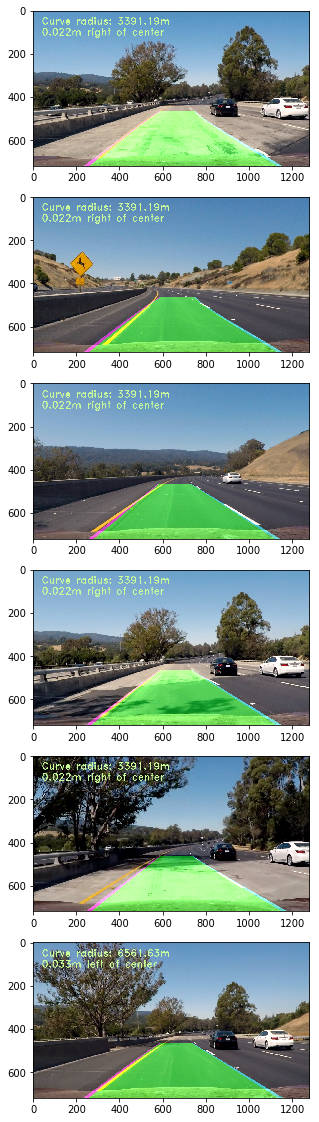

In [317]:
l_line = NLine()
r_line = NLine()

def process_image_test():
    # Set up plot to display test images with the lanes overlaid
    test_image_count = 6

    fig, axs = plt.subplots(test_image_count,1, figsize=(10, 20))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    ndx = 0

    test1_img = mpimg.imread('test_images/test1.jpg')
    lane1_img = process_image(test1_img)
    axs[ndx].imshow(lane1_img)
    ndx += 1

    test2_img = mpimg.imread('test_images/test2.jpg')
    lane2_img = process_image(test2_img)
    axs[ndx].imshow(lane2_img)
    ndx += 1

    test3_img = mpimg.imread('test_images/test3.jpg')
    lane3_img = process_image(test3_img)
    axs[ndx].imshow(lane3_img)
    ndx += 1

    test4_img = mpimg.imread('test_images/test4.jpg')
    lane4_img = process_image(test4_img)
    axs[ndx].imshow(lane4_img)
    ndx += 1

    test5_img = mpimg.imread('test_images/test5.jpg')
    lane5_img = process_image(test5_img)
    axs[ndx].imshow(lane5_img)
    ndx += 1

    test6_img = mpimg.imread('test_images/test6.jpg')
    lane6_img = process_image(test6_img)
    axs[ndx].imshow(lane6_img)


# Pipeline test
process_image_test()


## Process the project video stream

In [318]:
from moviepy.editor import VideoFileClip

# Left and Right Line objects
l_line = NLine()
r_line = NLine()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)



t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

SLIDE WINDOW!
Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4




t:   0%|          | 2/1260 [00:00<01:57, 10.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   0%|          | 3/1260 [00:00<02:38,  7.93it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   0%|          | 5/1260 [00:00<03:15,  6.43it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.336100531679
avg_rad= 9708.23434934
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:   1%|          | 8/1260 [00:01<03:24,  6.12it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   1%|          | 10/1260 [00:01<03:22,  6.18it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.303053387388
avg_rad= 3657.46123087



t:   1%|          | 12/1260 [00:01<03:23,  6.13it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   1%|          | 14/1260 [00:02<03:20,  6.23it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   1%|▏         | 16/1260 [00:02<03:22,  6.15it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.48016262101
avg_rad= 4821.59504177
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   1%|▏         | 18/1260 [00:02<03:24,  6.08it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   2%|▏         | 20/1260 [00:03<03:24,  6.06it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.349593785363
avg_rad= 26253.9489533



t:   2%|▏         | 22/1260 [00:03<03:23,  6.08it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   2%|▏         | 24/1260 [00:03<03:26,  5.98it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   2%|▏         | 25/1260 [00:04<03:29,  5.89it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.240526929106
avg_rad= 6859.5026399
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   2%|▏         | 28/1260 [00:04<03:39,  5.61it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   2%|▏         | 29/1260 [00:04<03:34,  5.75it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   2%|▏         | 31/1260 [00:05<03:31,  5.81it/s, now=None]

center_dist= 0.260568418815
avg_rad= 21141.4904192
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   3%|▎         | 32/1260 [00:05<03:50,  5.33it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:   3%|▎         | 33/1260 [00:05<03:50,  5.33it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   3%|▎         | 35/1260 [00:05<03:48,  5.36it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.126929870656
avg_rad= 3638.09667473
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   3%|▎         | 38/1260 [00:06<03:36,  5.64it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   3%|▎         | 40/1260 [00:06<03:29,  5.81it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.313748583103
avg_rad= 13211.6856365



t:   3%|▎         | 41/1260 [00:06<03:34,  5.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   3%|▎         | 43/1260 [00:07<03:37,  5.60it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   3%|▎         | 44/1260 [00:07<03:54,  5.19it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   4%|▎         | 45/1260 [00:07<03:59,  5.07it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.278442177813
avg_rad= 5848.70827406
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   4%|▎         | 47/1260 [00:08<03:43,  5.42it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   4%|▍         | 49/1260 [00:08<03:41,  5.46it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   4%|▍         | 50/1260 [00:08<04:03,  4.97it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.244780408114
avg_rad= 3363.25216646



t:   4%|▍         | 51/1260 [00:08<04:08,  4.87it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   4%|▍         | 52/1260 [00:09<04:20,  4.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   4%|▍         | 54/1260 [00:09<04:07,  4.88it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   4%|▍         | 55/1260 [00:09<04:19,  4.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.308895156434
avg_rad= 40038.4998605



t:   4%|▍         | 56/1260 [00:09<04:20,  4.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:   5%|▍         | 57/1260 [00:10<04:13,  4.74it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   5%|▍         | 59/1260 [00:10<03:50,  5.22it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   5%|▍         | 60/1260 [00:10<03:56,  5.08it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.14484837392
avg_rad= 5109.89950324
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   5%|▍         | 62/1260 [00:11<03:45,  5.32it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   5%|▌         | 65/1260 [00:11<03:35,  5.54it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.275073039138
avg_rad= 12009.7135181



t:   5%|▌         | 66/1260 [00:11<03:35,  5.55it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   5%|▌         | 69/1260 [00:12<03:36,  5.51it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   6%|▌         | 70/1260 [00:12<03:34,  5.56it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.139429715801
avg_rad= 17942.9039742
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   6%|▌         | 72/1260 [00:12<03:35,  5.52it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   6%|▌         | 74/1260 [00:13<03:31,  5.60it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   6%|▌         | 76/1260 [00:13<03:28,  5.68it/s, now=None]

center_dist= 0.0721450405353
avg_rad= 4852.31722654
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   6%|▌         | 78/1260 [00:13<03:27,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   6%|▋         | 79/1260 [00:14<03:30,  5.61it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0970261388386
avg_rad= 37059.3893226



t:   7%|▋         | 82/1260 [00:14<03:24,  5.75it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   7%|▋         | 84/1260 [00:15<03:21,  5.84it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   7%|▋         | 86/1260 [00:15<03:23,  5.77it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0334248264312
avg_rad= 75840.4043872
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   7%|▋         | 88/1260 [00:15<03:20,  5.84it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   7%|▋         | 90/1260 [00:16<03:17,  5.93it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.109046276065
avg_rad= 6589.43104253



t:   7%|▋         | 91/1260 [00:16<03:19,  5.87it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:   7%|▋         | 93/1260 [00:16<03:21,  5.78it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   8%|▊         | 95/1260 [00:16<03:17,  5.89it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0105062659136
avg_rad= 7987.06663253



t:   8%|▊         | 97/1260 [00:17<03:16,  5.92it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   8%|▊         | 98/1260 [00:17<03:16,  5.91it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   8%|▊         | 100/1260 [00:17<03:36,  5.36it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0338090483804
avg_rad= 4064.76494933



t:   8%|▊         | 101/1260 [00:18<03:45,  5.13it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:   8%|▊         | 103/1260 [00:18<03:39,  5.27it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   8%|▊         | 104/1260 [00:18<03:33,  5.41it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0517666861292
avg_rad= 22869.0565635



t:   8%|▊         | 106/1260 [00:18<03:36,  5.33it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   9%|▊         | 108/1260 [00:19<03:28,  5.52it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   9%|▊         | 110/1260 [00:19<03:28,  5.51it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.104485064154
avg_rad= 6392.32523608



t:   9%|▉         | 111/1260 [00:19<03:39,  5.23it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:   9%|▉         | 113/1260 [00:20<03:36,  5.29it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   9%|▉         | 115/1260 [00:20<03:31,  5.43it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.191741650275
avg_rad= 77055.7407457



t:   9%|▉         | 117/1260 [00:20<03:25,  5.57it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:   9%|▉         | 119/1260 [00:21<03:19,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  10%|▉         | 120/1260 [00:21<03:18,  5.75it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.154648351931
avg_rad= 4462.66241863
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  10%|▉         | 122/1260 [00:21<03:35,  5.27it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  10%|▉         | 124/1260 [00:22<03:28,  5.45it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  10%|█         | 126/1260 [00:22<03:20,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.182644483823
avg_rad= 3480.71931415
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  10%|█         | 128/1260 [00:22<03:14,  5.82it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  10%|█         | 130/1260 [00:23<03:12,  5.86it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.246817028243
avg_rad= 4295.84604333



t:  10%|█         | 131/1260 [00:23<03:21,  5.59it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  10%|█         | 132/1260 [00:23<03:31,  5.33it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  11%|█         | 133/1260 [00:23<03:42,  5.06it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  11%|█         | 134/1260 [00:24<03:41,  5.08it/s, now=None]

L-R Line  off count= 0



t:  11%|█         | 135/1260 [00:24<03:54,  4.80it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.128268259746
avg_rad= 2922.62247336



t:  11%|█         | 136/1260 [00:24<03:53,  4.81it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  11%|█         | 137/1260 [00:24<04:02,  4.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  11%|█         | 139/1260 [00:25<03:40,  5.08it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  11%|█         | 141/1260 [00:25<03:27,  5.41it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.362825031439
avg_rad= 8716.89745748
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  11%|█▏        | 142/1260 [00:25<03:22,  5.52it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  11%|█▏        | 143/1260 [00:25<03:27,  5.37it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  12%|█▏        | 145/1260 [00:26<03:24,  5.46it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.296152837329
avg_rad= 7801.86225741
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  12%|█▏        | 148/1260 [00:26<03:11,  5.80it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  12%|█▏        | 150/1260 [00:27<03:08,  5.88it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.294779919673
avg_rad= 5598.93761914



t:  12%|█▏        | 151/1260 [00:27<03:12,  5.77it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  12%|█▏        | 153/1260 [00:27<03:20,  5.51it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  12%|█▏        | 155/1260 [00:27<03:11,  5.79it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.309947886257
avg_rad= 8746.39397355



t:  12%|█▏        | 156/1260 [00:28<03:08,  5.87it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  13%|█▎        | 159/1260 [00:28<03:05,  5.92it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  13%|█▎        | 160/1260 [00:28<03:09,  5.81it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0778528301586
avg_rad= 4215.84549094
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  13%|█▎        | 162/1260 [00:29<03:21,  5.44it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  13%|█▎        | 164/1260 [00:29<03:26,  5.31it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  13%|█▎        | 166/1260 [00:29<03:25,  5.33it/s, now=None]

center_dist= 0.325974048879
avg_rad= 5193.24308862
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  13%|█▎        | 167/1260 [00:30<03:24,  5.33it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  13%|█▎        | 169/1260 [00:30<03:24,  5.33it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.194963178083
avg_rad= 23314.5235362



t:  14%|█▎        | 172/1260 [00:31<03:14,  5.59it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  14%|█▍        | 174/1260 [00:31<03:13,  5.61it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  14%|█▍        | 176/1260 [00:31<03:09,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0625564452432
avg_rad= 4330.77401679
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  14%|█▍        | 177/1260 [00:31<03:10,  5.70it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  14%|█▍        | 179/1260 [00:32<03:17,  5.48it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.122343778072
avg_rad= 7642.69345517



t:  14%|█▍        | 181/1260 [00:32<03:19,  5.41it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  14%|█▍        | 182/1260 [00:32<03:31,  5.09it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  15%|█▍        | 184/1260 [00:33<03:21,  5.35it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  15%|█▍        | 186/1260 [00:33<03:18,  5.42it/s, now=None]

L-R Line  off count= 0
center_dist= 0.010253478742
avg_rad= 3179.02674142
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  15%|█▍        | 187/1260 [00:33<03:10,  5.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  15%|█▌        | 190/1260 [00:34<03:08,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.202658081714
avg_rad= 8866.74425229



t:  15%|█▌        | 191/1260 [00:34<03:07,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  15%|█▌        | 193/1260 [00:34<03:08,  5.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  15%|█▌        | 195/1260 [00:35<03:08,  5.64it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.197371119065
avg_rad= 3368.56893706
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  16%|█▌        | 197/1260 [00:35<03:06,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  16%|█▌        | 198/1260 [00:35<03:27,  5.11it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  16%|█▌        | 200/1260 [00:36<03:10,  5.55it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.138258304082
avg_rad= 3736.42365386
SEARCH AROUND WINDOW!



t:  16%|█▌        | 202/1260 [00:36<03:11,  5.52it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  16%|█▌        | 204/1260 [00:36<03:06,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  16%|█▋        | 206/1260 [00:37<03:00,  5.83it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.184304775593
avg_rad= 42103.5077006
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  17%|█▋        | 208/1260 [00:37<02:58,  5.90it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  17%|█▋        | 210/1260 [00:37<02:55,  5.97it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.033833225644
avg_rad= 3560.84875807



t:  17%|█▋        | 212/1260 [00:38<02:56,  5.94it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  17%|█▋        | 213/1260 [00:38<03:03,  5.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  17%|█▋        | 215/1260 [00:38<03:14,  5.38it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.189080032065
avg_rad= 13101.0073699
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  17%|█▋        | 217/1260 [00:39<03:28,  5.01it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  17%|█▋        | 219/1260 [00:39<03:17,  5.27it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0910942819364
avg_rad= 5196.80344257



t:  18%|█▊        | 221/1260 [00:39<03:17,  5.25it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  18%|█▊        | 223/1260 [00:40<03:10,  5.44it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  18%|█▊        | 225/1260 [00:40<03:05,  5.57it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0837146892342
avg_rad= 4712.97682932
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  18%|█▊        | 228/1260 [00:41<03:01,  5.70it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  18%|█▊        | 230/1260 [00:41<02:55,  5.86it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0469998502057
avg_rad= 17497.5270313



t:  18%|█▊        | 231/1260 [00:41<02:53,  5.92it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  18%|█▊        | 233/1260 [00:41<02:55,  5.85it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  19%|█▊        | 235/1260 [00:42<02:59,  5.70it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.166323055851
avg_rad= 4363.65618758



t:  19%|█▊        | 236/1260 [00:42<03:03,  5.59it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  19%|█▉        | 239/1260 [00:43<02:55,  5.82it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  19%|█▉        | 240/1260 [00:43<02:55,  5.81it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0528607880437
avg_rad= 22815.1741801
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  19%|█▉        | 243/1260 [00:43<02:54,  5.81it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  19%|█▉        | 244/1260 [00:43<02:56,  5.76it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.13293292579
avg_rad= 5659.54825485



t:  20%|█▉        | 246/1260 [00:44<02:59,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  20%|█▉        | 249/1260 [00:44<02:52,  5.85it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  20%|█▉        | 251/1260 [00:45<02:52,  5.86it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.140756286006
avg_rad= 4996.07902172
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  20%|██        | 253/1260 [00:45<02:55,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  20%|██        | 255/1260 [00:45<02:50,  5.90it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.158812218872
avg_rad= 5514.8376487



t:  20%|██        | 256/1260 [00:45<02:50,  5.88it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  21%|██        | 259/1260 [00:46<02:51,  5.83it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  21%|██        | 260/1260 [00:46<02:49,  5.90it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.245382673723
avg_rad= 3934.78577285
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  21%|██        | 263/1260 [00:47<02:51,  5.81it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  21%|██        | 265/1260 [00:47<02:49,  5.89it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0936442816891
avg_rad= 13342.6341186



t:  21%|██        | 266/1260 [00:47<02:48,  5.91it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  21%|██▏       | 268/1260 [00:48<02:49,  5.86it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  21%|██▏       | 270/1260 [00:48<03:14,  5.08it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.122239161891
avg_rad= 5271.85772804



t:  22%|██▏       | 271/1260 [00:48<03:29,  4.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  22%|██▏       | 272/1260 [00:48<03:47,  4.35it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  22%|██▏       | 273/1260 [00:49<03:52,  4.25it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  22%|██▏       | 274/1260 [00:49<03:59,  4.12it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  22%|██▏       | 275/1260 [00:49<04:02,  4.06it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0206111091255
avg_rad= 7320.11248623



t:  22%|██▏       | 277/1260 [00:50<03:29,  4.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  22%|██▏       | 278/1260 [00:50<03:18,  4.94it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  22%|██▏       | 279/1260 [00:50<03:21,  4.87it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  22%|██▏       | 280/1260 [00:50<03:28,  4.70it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0472629597627
avg_rad= 6372.76442102



t:  22%|██▏       | 281/1260 [00:50<03:34,  4.57it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  22%|██▏       | 282/1260 [00:51<03:38,  4.47it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  22%|██▏       | 283/1260 [00:51<03:31,  4.61it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  23%|██▎       | 285/1260 [00:51<03:21,  4.85it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.00705524083943
avg_rad= 5407.74507779



t:  23%|██▎       | 286/1260 [00:52<03:26,  4.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  23%|██▎       | 287/1260 [00:52<03:31,  4.60it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  23%|██▎       | 288/1260 [00:52<03:34,  4.53it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  23%|██▎       | 289/1260 [00:52<03:33,  4.54it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  23%|██▎       | 290/1260 [00:52<03:25,  4.72it/s, now=None]

L-R Line  off count= 0
center_dist= 0.0663856354243
avg_rad= 13589.5841251
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  23%|██▎       | 293/1260 [00:53<02:59,  5.39it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  23%|██▎       | 294/1260 [00:53<02:55,  5.52it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  23%|██▎       | 296/1260 [00:53<02:52,  5.58it/s, now=None]

center_dist= 0.014404889415
avg_rad= 5969.73198893
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  24%|██▎       | 298/1260 [00:54<02:47,  5.76it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  24%|██▎       | 299/1260 [00:54<02:46,  5.75it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.155066149018
avg_rad= 8810.65359252



t:  24%|██▍       | 301/1260 [00:54<02:52,  5.56it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  24%|██▍       | 302/1260 [00:55<02:56,  5.42it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  24%|██▍       | 303/1260 [00:55<03:02,  5.25it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  24%|██▍       | 305/1260 [00:55<03:10,  5.00it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.100526363961
avg_rad= 11900.8614654
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  24%|██▍       | 308/1260 [00:56<02:51,  5.54it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  25%|██▍       | 310/1260 [00:56<02:52,  5.51it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.157587659123
avg_rad= 18078.2370901



t:  25%|██▍       | 312/1260 [00:56<02:45,  5.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  25%|██▍       | 313/1260 [00:57<02:53,  5.46it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  25%|██▌       | 316/1260 [00:57<02:45,  5.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.15478915963
avg_rad= 14053.5993248
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  25%|██▌       | 318/1260 [00:57<02:45,  5.68it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  25%|██▌       | 320/1260 [00:58<02:46,  5.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0612849499492
avg_rad= 26632.2624627



t:  26%|██▌       | 322/1260 [00:58<02:41,  5.82it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  26%|██▌       | 323/1260 [00:58<02:42,  5.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  26%|██▌       | 325/1260 [00:59<02:42,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.162580983475
avg_rad= 38625.2822417
SEARCH AROUND WINDOW!



t:  26%|██▌       | 326/1260 [00:59<02:53,  5.39it/s, now=None]

L-R Line  off count= 0



t:  26%|██▌       | 327/1260 [00:59<03:08,  4.94it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  26%|██▌       | 328/1260 [00:59<03:18,  4.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  26%|██▌       | 329/1260 [01:00<03:15,  4.76it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  26%|██▌       | 330/1260 [01:00<03:13,  4.80it/s, now=None]

L-R Line  off count= 0
center_dist= 0.120989909826
avg_rad= 32481.9568162
SEARCH AROUND WINDOW!



t:  26%|██▋       | 331/1260 [01:00<03:14,  4.78it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  26%|██▋       | 332/1260 [01:00<03:15,  4.76it/s, now=None]

L-R Line  off count= 0



t:  26%|██▋       | 333/1260 [01:00<03:25,  4.51it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  27%|██▋       | 334/1260 [01:01<03:17,  4.68it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  27%|██▋       | 335/1260 [01:01<03:14,  4.75it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.157297517817
avg_rad= 243304.864596
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  27%|██▋       | 337/1260 [01:01<03:01,  5.08it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  27%|██▋       | 339/1260 [01:02<02:49,  5.43it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  27%|██▋       | 341/1260 [01:02<02:44,  5.57it/s, now=None]

center_dist= 0.160015060607
avg_rad= 56684.9250555
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  27%|██▋       | 342/1260 [01:02<02:43,  5.60it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  27%|██▋       | 344/1260 [01:02<02:47,  5.47it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  27%|██▋       | 346/1260 [01:03<02:47,  5.47it/s, now=None]

center_dist= 0.163199722486
avg_rad= 67143.9573373
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  28%|██▊       | 348/1260 [01:03<02:40,  5.70it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  28%|██▊       | 349/1260 [01:03<02:37,  5.79it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  28%|██▊       | 351/1260 [01:04<02:37,  5.77it/s, now=None]

center_dist= 0.200605137686
avg_rad= 10840.7083133
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  28%|██▊       | 352/1260 [01:04<02:35,  5.85it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  28%|██▊       | 355/1260 [01:04<02:33,  5.90it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0421192993972
avg_rad= 20812.0545417



t:  28%|██▊       | 356/1260 [01:05<02:33,  5.89it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  28%|██▊       | 359/1260 [01:05<02:33,  5.87it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  29%|██▊       | 360/1260 [01:05<02:31,  5.95it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.192074126541
avg_rad= 6729.88029615
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  29%|██▊       | 362/1260 [01:06<02:35,  5.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  29%|██▉       | 365/1260 [01:06<02:33,  5.83it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.177913787245
avg_rad= 37304.1335432



t:  29%|██▉       | 367/1260 [01:06<02:33,  5.83it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  29%|██▉       | 369/1260 [01:07<02:32,  5.84it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  29%|██▉       | 370/1260 [01:07<02:33,  5.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.256893506207
avg_rad= 9060.49127661



t:  29%|██▉       | 371/1260 [01:07<02:46,  5.35it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  30%|██▉       | 374/1260 [01:08<02:36,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  30%|██▉       | 376/1260 [01:08<02:31,  5.83it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.169792910735
avg_rad= 10002.0905325
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  30%|██▉       | 377/1260 [01:08<02:32,  5.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  30%|███       | 380/1260 [01:09<02:31,  5.82it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0699433268809
avg_rad= 21291.4767216



t:  30%|███       | 381/1260 [01:09<02:33,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  30%|███       | 383/1260 [01:09<02:32,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  31%|███       | 386/1260 [01:10<02:30,  5.79it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.120752473223
avg_rad= 10483.4225492
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  31%|███       | 387/1260 [01:10<02:30,  5.81it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  31%|███       | 390/1260 [01:10<02:32,  5.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.108108003939
avg_rad= 73410.5855671



t:  31%|███       | 391/1260 [01:11<02:32,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  31%|███       | 393/1260 [01:11<02:37,  5.50it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  31%|███▏      | 395/1260 [01:11<02:40,  5.40it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.176450971905
avg_rad= 552463.193134
SEARCH AROUND WINDOW!



t:  32%|███▏      | 397/1260 [01:12<02:40,  5.39it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  32%|███▏      | 398/1260 [01:12<02:34,  5.57it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  32%|███▏      | 400/1260 [01:12<02:34,  5.56it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0768271773345
avg_rad= 45557.2834974
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  32%|███▏      | 402/1260 [01:13<02:32,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  32%|███▏      | 405/1260 [01:13<02:30,  5.70it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0236200112234
avg_rad= 11681.6925512



t:  32%|███▏      | 407/1260 [01:14<02:27,  5.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  32%|███▏      | 408/1260 [01:14<02:26,  5.81it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  33%|███▎      | 410/1260 [01:14<02:26,  5.82it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0645888173837
avg_rad= 24359.4893267
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  33%|███▎      | 413/1260 [01:15<02:27,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  33%|███▎      | 415/1260 [01:15<02:26,  5.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0660338834976
avg_rad= 14909.258058



t:  33%|███▎      | 416/1260 [01:15<02:24,  5.84it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  33%|███▎      | 418/1260 [01:15<02:27,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  33%|███▎      | 420/1260 [01:16<02:26,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.00217919702855
avg_rad= 13101.9444236
SEARCH AROUND WINDOW!



t:  33%|███▎      | 422/1260 [01:16<02:30,  5.58it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  34%|███▎      | 423/1260 [01:16<02:30,  5.57it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 


t:  34%|███▎      | 425/1260 [01:17<02:33,  5.46it/s, now=None]

0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0840343672789
avg_rad= 20888.7639556
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  34%|███▍      | 427/1260 [01:17<02:31,  5.51it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  34%|███▍      | 429/1260 [01:17<02:27,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.141673715367
avg_rad= 18491.0950248



t:  34%|███▍      | 431/1260 [01:18<02:25,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  34%|███▍      | 433/1260 [01:18<02:25,  5.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  35%|███▍      | 435/1260 [01:18<02:29,  5.53it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.12023370794
avg_rad= 142357.768106



t:  35%|███▍      | 436/1260 [01:19<02:37,  5.25it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  35%|███▍      | 437/1260 [01:19<02:36,  5.27it/s, now=None]


L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  35%|███▍      | 439/1260 [01:19<02:30,  5.44it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  35%|███▌      | 441/1260 [01:20<02:28,  5.52it/s, now=None]

center_dist= -0.246957084922
avg_rad= 119559.094505
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  35%|███▌      | 443/1260 [01:20<02:23,  5.68it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  35%|███▌      | 445/1260 [01:20<02:22,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.139537773193
avg_rad= 10552.31182



t:  35%|███▌      | 446/1260 [01:20<02:28,  5.48it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  36%|███▌      | 449/1260 [01:21<02:25,  5.56it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  36%|███▌      | 450/1260 [01:21<02:25,  5.56it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.311288825019
avg_rad= 9626.92240226



t:  36%|███▌      | 451/1260 [01:21<02:33,  5.28it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  36%|███▌      | 453/1260 [01:22<02:31,  5.34it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  36%|███▌      | 456/1260 [01:22<02:26,  5.48it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.166326861359
avg_rad= 23720.3056847
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  36%|███▋      | 457/1260 [01:23<02:28,  5.41it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  36%|███▋      | 459/1260 [01:23<02:22,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.197480816495
avg_rad= 53297.1092836



t:  37%|███▋      | 461/1260 [01:23<02:20,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  37%|███▋      | 463/1260 [01:24<02:17,  5.79it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  37%|███▋      | 465/1260 [01:24<02:22,  5.60it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.213688440893
avg_rad= 29774.5335909
SEARCH AROUND WINDOW!



t:  37%|███▋      | 466/1260 [01:24<02:27,  5.39it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  37%|███▋      | 468/1260 [01:25<02:27,  5.36it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  37%|███▋      | 470/1260 [01:25<02:23,  5.50it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.177056795918
avg_rad= 11350.6147054
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  37%|███▋      | 472/1260 [01:25<02:19,  5.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  38%|███▊      | 474/1260 [01:26<02:17,  5.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.268232529479
avg_rad= 8811.49552584



t:  38%|███▊      | 476/1260 [01:26<02:16,  5.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  38%|███▊      | 479/1260 [01:26<02:15,  5.77it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  38%|███▊      | 480/1260 [01:27<02:18,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.11058764119
avg_rad= 287108.185716
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  38%|███▊      | 482/1260 [01:27<02:19,  5.59it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  38%|███▊      | 484/1260 [01:27<02:15,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.147742296861
avg_rad= 34782.658295



t:  39%|███▊      | 486/1260 [01:28<02:14,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  39%|███▊      | 488/1260 [01:28<02:17,  5.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  39%|███▉      | 490/1260 [01:28<02:13,  5.75it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.10063128963
avg_rad= 157986.61508
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  39%|███▉      | 493/1260 [01:29<02:11,  5.82it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  39%|███▉      | 495/1260 [01:29<02:09,  5.88it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.117897637432
avg_rad= 53334.4992065



t:  39%|███▉      | 496/1260 [01:29<02:12,  5.76it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  40%|███▉      | 498/1260 [01:30<02:16,  5.60it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  40%|███▉      | 500/1260 [01:30<02:15,  5.60it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.23172988592
avg_rad= 13688.6037689
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  40%|███▉      | 502/1260 [01:30<02:16,  5.53it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  40%|████      | 504/1260 [01:31<02:14,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  40%|████      | 506/1260 [01:31<02:12,  5.70it/s, now=None]

center_dist= -0.0594253557688
avg_rad= 37130.4078498
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  40%|████      | 508/1260 [01:32<02:11,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  40%|████      | 510/1260 [01:32<02:13,  5.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.1423582755
avg_rad= 51946.2865576



t:  41%|████      | 511/1260 [01:32<02:14,  5.59it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  41%|████      | 513/1260 [01:32<02:14,  5.54it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  41%|████      | 515/1260 [01:33<02:14,  5.55it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.134799769428
avg_rad= 36860.1965377
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  41%|████      | 517/1260 [01:33<02:11,  5.64it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  41%|████      | 519/1260 [01:34<02:11,  5.61it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  41%|████▏     | 521/1260 [01:34<02:13,  5.53it/s, now=None]

center_dist= -0.116432945959
avg_rad= 159176.026818
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  41%|████▏     | 522/1260 [01:34<02:13,  5.53it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  42%|████▏     | 523/1260 [01:34<02:19,  5.30it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  42%|████▏     | 525/1260 [01:35<02:17,  5.33it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.152356389195
avg_rad= 1357505.8359



t:  42%|████▏     | 526/1260 [01:35<02:18,  5.29it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  42%|████▏     | 527/1260 [01:35<02:22,  5.16it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  42%|████▏     | 529/1260 [01:35<02:17,  5.30it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  42%|████▏     | 530/1260 [01:36<02:17,  5.30it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.103926227664
avg_rad= 156082.571601



t:  42%|████▏     | 531/1260 [01:36<02:29,  4.87it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  42%|████▏     | 532/1260 [01:36<02:40,  4.52it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  42%|████▏     | 533/1260 [01:36<02:37,  4.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  42%|████▏     | 534/1260 [01:37<02:32,  4.76it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  42%|████▏     | 535/1260 [01:37<02:29,  4.85it/s, now=None]

center_dist= -0.0991258511156
avg_rad= 124186.637014
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  43%|████▎     | 537/1260 [01:37<02:21,  5.11it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  43%|████▎     | 539/1260 [01:37<02:13,  5.39it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  43%|████▎     | 540/1260 [01:38<02:13,  5.40it/s, now=None]

center_dist= -0.347689531111
avg_rad= 3513.30143692
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  43%|████▎     | 542/1260 [01:38<02:18,  5.17it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  43%|████▎     | 544/1260 [01:38<02:17,  5.22it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0277423388292
avg_rad= 6236.0893209



t:  43%|████▎     | 546/1260 [01:39<02:10,  5.46it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  43%|████▎     | 547/1260 [01:39<02:20,  5.08it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  43%|████▎     | 548/1260 [01:39<02:19,  5.11it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  44%|████▎     | 549/1260 [01:39<02:21,  5.03it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.260997145332
avg_rad= 4037.53770131



t:  44%|████▎     | 551/1260 [01:40<02:15,  5.22it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  44%|████▍     | 553/1260 [01:40<02:16,  5.17it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  44%|████▍     | 555/1260 [01:41<02:15,  5.22it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.11672614239
avg_rad= 3836.81828068
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  44%|████▍     | 557/1260 [01:41<02:14,  5.23it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  44%|████▍     | 558/1260 [01:41<02:25,  4.84it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  44%|████▍     | 559/1260 [01:41<02:49,  4.14it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  44%|████▍     | 560/1260 [01:42<02:54,  4.01it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.265162906263
avg_rad= 4337.12053284



t:  45%|████▍     | 561/1260 [01:42<03:00,  3.87it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  45%|████▍     | 562/1260 [01:42<02:59,  3.88it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  45%|████▍     | 563/1260 [01:43<03:03,  3.80it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  45%|████▍     | 564/1260 [01:43<02:50,  4.07it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  45%|████▍     | 566/1260 [01:43<02:30,  4.61it/s, now=None]

L-R Line  off count= 0
center_dist= -0.0609034825617
avg_rad= 53126.4597289
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  45%|████▌     | 567/1260 [01:43<02:22,  4.87it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  45%|████▌     | 570/1260 [01:44<02:12,  5.19it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.170202025751
avg_rad= 63400.476882



t:  45%|████▌     | 571/1260 [01:44<02:09,  5.31it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  46%|████▌     | 574/1260 [01:45<02:02,  5.59it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  46%|████▌     | 576/1260 [01:45<02:00,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.060982778891
avg_rad= 23143.703788
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  46%|████▌     | 577/1260 [01:45<02:01,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  46%|████▌     | 579/1260 [01:45<02:02,  5.56it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0152504157758
avg_rad= 27701.894369



t:  46%|████▌     | 582/1260 [01:46<01:59,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
Fit ERROR: l_diff= [  4.05824914e-04   4.59988524e-01   1.24209730e+02]  r_diff= [  4.02797348e-05   6.32436946e-03   1.13912929e+01]
L-R Line  off count= 0
ERROR - invalid lines detected!



t:  46%|████▋     | 583/1260 [01:46<02:02,  5.50it/s, now=None]

SEARCH AROUND WINDOW!
Fit ERROR: l_diff= [  4.13030156e-04   4.67268846e-01   1.26989274e+02]  r_diff= [  6.82451175e-05   2.37388179e-02   1.00030619e+01]
L-R Line  off count= 0
ERROR - invalid lines detected!



t:  46%|████▋     | 585/1260 [01:47<02:02,  5.49it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 8.68599290917e-05
avg_rad= 9666.71806531



t:  47%|████▋     | 587/1260 [01:47<01:58,  5.68it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  47%|████▋     | 588/1260 [01:47<01:59,  5.64it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  47%|████▋     | 590/1260 [01:47<02:02,  5.47it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.357083142035
avg_rad= 3253.5916787
SEARCH AROUND WINDOW!



t:  47%|████▋     | 592/1260 [01:48<02:00,  5.52it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  47%|████▋     | 594/1260 [01:48<02:01,  5.49it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  47%|████▋     | 595/1260 [01:48<01:57,  5.64it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0709105116918
avg_rad= 3345.84948547
SEARCH AROUND WINDOW!



t:  47%|████▋     | 597/1260 [01:49<02:00,  5.52it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  48%|████▊     | 599/1260 [01:49<01:55,  5.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  48%|████▊     | 601/1260 [01:49<01:55,  5.70it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0692016113688
avg_rad= 3281.49856881
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  48%|████▊     | 602/1260 [01:50<01:56,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  48%|████▊     | 604/1260 [01:50<01:55,  5.70it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.10853943778
avg_rad= 2956.52570397



t:  48%|████▊     | 606/1260 [01:50<01:53,  5.76it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  48%|████▊     | 608/1260 [01:51<01:55,  5.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  48%|████▊     | 611/1260 [01:51<01:58,  5.46it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.171855220022
avg_rad= 9812.53574779
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  49%|████▊     | 612/1260 [01:51<02:01,  5.34it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  49%|████▊     | 614/1260 [01:52<01:59,  5.40it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0831043715444
avg_rad= 2226.21529648



t:  49%|████▉     | 616/1260 [01:52<02:01,  5.32it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  49%|████▉     | 618/1260 [01:53<01:58,  5.42it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  49%|████▉     | 620/1260 [01:53<01:59,  5.34it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.48208607555
avg_rad= 5215.37049272



t:  49%|████▉     | 621/1260 [01:53<01:58,  5.40it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  49%|████▉     | 623/1260 [01:53<01:59,  5.31it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  50%|████▉     | 625/1260 [01:54<01:56,  5.47it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.343758521457
avg_rad= 3297.68008058
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  50%|████▉     | 627/1260 [01:54<01:53,  5.59it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  50%|████▉     | 629/1260 [01:55<01:55,  5.47it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.304882654428
avg_rad= 11252.6150855



t:  50%|█████     | 631/1260 [01:55<01:56,  5.41it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  50%|█████     | 633/1260 [01:55<01:54,  5.50it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  50%|█████     | 634/1260 [01:55<01:57,  5.35it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  50%|█████     | 635/1260 [01:56<01:57,  5.32it/s, now=None]

center_dist= -0.221106250485
avg_rad= 4791.46450811
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  51%|█████     | 637/1260 [01:56<02:03,  5.05it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  51%|█████     | 639/1260 [01:56<01:56,  5.32it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  51%|█████     | 641/1260 [01:57<01:55,  5.36it/s, now=None]

center_dist= -0.186074589768
avg_rad= 4871.74281076
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  51%|█████     | 643/1260 [01:57<01:51,  5.54it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  51%|█████     | 644/1260 [01:57<02:00,  5.09it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  51%|█████     | 645/1260 [01:58<02:08,  4.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.157427854498
avg_rad= 16719.0578561



t:  51%|█████▏    | 646/1260 [01:58<02:07,  4.80it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  51%|█████▏    | 647/1260 [01:58<02:12,  4.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  51%|█████▏    | 648/1260 [01:58<02:17,  4.44it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  52%|█████▏    | 650/1260 [01:59<02:01,  5.03it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.032491254551
avg_rad= 5299.12406229
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  52%|█████▏    | 652/1260 [01:59<01:53,  5.38it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  52%|█████▏    | 654/1260 [01:59<01:48,  5.57it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0457145367812
avg_rad= 7792.70850095


t:  52%|█████▏    | 657/1260 [02:00<01:47,  5.60it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  52%|█████▏    | 658/1260 [02:00<01:47,  5.61it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  52%|█████▏    | 660/1260 [02:00<01:47,  5.60it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0965707833382
avg_rad= 3754.47250806
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  53%|█████▎    | 663/1260 [02:01<01:46,  5.61it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  53%|█████▎    | 665/1260 [02:01<01:43,  5.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0279520494317
avg_rad= 5547.53452738



t:  53%|█████▎    | 667/1260 [02:02<01:42,  5.80it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  53%|█████▎    | 668/1260 [02:02<01:43,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  53%|█████▎    | 670/1260 [02:02<01:48,  5.45it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0748049985228
avg_rad= 5539.49194601



t:  53%|█████▎    | 671/1260 [02:02<01:52,  5.23it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  53%|█████▎    | 674/1260 [02:03<01:44,  5.59it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  54%|█████▎    | 675/1260 [02:03<01:44,  5.58it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0816654177033
avg_rad= 4584.38292066
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  54%|█████▎    | 677/1260 [02:03<01:43,  5.61it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  54%|█████▍    | 679/1260 [02:04<01:44,  5.58it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  54%|█████▍    | 680/1260 [02:04<01:41,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0227506622042
avg_rad= 11172.1702909
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  54%|█████▍    | 682/1260 [02:04<01:41,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  54%|█████▍    | 684/1260 [02:05<01:40,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  54%|█████▍    | 686/1260 [02:05<01:41,  5.66it/s, now=None]

center_dist= 0.182356254162
avg_rad= 4593.6284488
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  55%|█████▍    | 687/1260 [02:05<01:41,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  55%|█████▍    | 690/1260 [02:06<01:39,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0936866309249
avg_rad= 7215.86007251



t:  55%|█████▍    | 691/1260 [02:06<01:38,  5.79it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  55%|█████▌    | 693/1260 [02:06<01:39,  5.71it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  55%|█████▌    | 696/1260 [02:07<01:36,  5.86it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0286528605061
avg_rad= 46156.4991431
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  55%|█████▌    | 697/1260 [02:07<01:40,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  56%|█████▌    | 700/1260 [02:08<01:35,  5.85it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0915089610575
avg_rad= 5212.85955754



t:  56%|█████▌    | 702/1260 [02:08<01:36,  5.80it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  56%|█████▌    | 704/1260 [02:08<01:35,  5.83it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  56%|█████▌    | 706/1260 [02:09<01:33,  5.90it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.00153278683199
avg_rad= 17283.683949
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  56%|█████▌    | 707/1260 [02:09<01:34,  5.87it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  56%|█████▋    | 710/1260 [02:09<01:35,  5.79it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.110805035318
avg_rad= 3638.19586714



t:  56%|█████▋    | 711/1260 [02:09<01:36,  5.68it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  57%|█████▋    | 713/1260 [02:10<01:45,  5.17it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  57%|█████▋    | 714/1260 [02:10<01:50,  4.94it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  57%|█████▋    | 715/1260 [02:10<01:50,  4.92it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0337450802935
avg_rad= 4398.35612992
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  57%|█████▋    | 717/1260 [02:11<01:42,  5.28it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  57%|█████▋    | 719/1260 [02:11<01:37,  5.54it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0463620133394
avg_rad= 5821.15106907


t:  57%|█████▋    | 721/1260 [02:11<01:38,  5.47it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  57%|█████▋    | 722/1260 [02:12<01:47,  5.01it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  57%|█████▋    | 723/1260 [02:12<01:55,  4.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  57%|█████▋    | 724/1260 [02:12<02:02,  4.38it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  58%|█████▊    | 725/1260 [02:12<02:03,  4.33it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0902375122049
avg_rad= 5012.5848869
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  58%|█████▊    | 728/1260 [02:13<01:42,  5.18it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  58%|█████▊    | 729/1260 [02:13<01:40,  5.30it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  58%|█████▊    | 730/1260 [02:13<01:43,  5.11it/s, now=None]

L-R Line  off count= 0
center_dist= 0.0547100794155
avg_rad= 24453.1147097
SEARCH AROUND WINDOW!



t:  58%|█████▊    | 732/1260 [02:14<01:40,  5.23it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  58%|█████▊    | 734/1260 [02:14<01:35,  5.51it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  58%|█████▊    | 735/1260 [02:14<01:41,  5.17it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.205364888495
avg_rad= 3344.09317274



t:  58%|█████▊    | 736/1260 [02:14<01:45,  4.95it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  58%|█████▊    | 737/1260 [02:15<01:52,  4.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  59%|█████▊    | 738/1260 [02:15<01:49,  4.75it/s, now=None]

L-R Line  off count= 0



t:  59%|█████▊    | 739/1260 [02:15<01:51,  4.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  59%|█████▊    | 740/1260 [02:15<01:54,  4.53it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.183587808714
avg_rad= 4881.645259



t:  59%|█████▉    | 741/1260 [02:16<01:58,  4.38it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  59%|█████▉    | 743/1260 [02:16<01:46,  4.84it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  59%|█████▉    | 744/1260 [02:16<01:43,  5.00it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  59%|█████▉    | 745/1260 [02:16<01:44,  4.95it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.279048273503
avg_rad= 3681.47717461
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  59%|█████▉    | 747/1260 [02:17<01:36,  5.31it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  59%|█████▉    | 748/1260 [02:17<01:38,  5.18it/s, now=None]

L-R Line  off count= 0



t:  59%|█████▉    | 749/1260 [02:17<01:46,  4.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  60%|█████▉    | 750/1260 [02:17<01:48,  4.70it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.270331867847
avg_rad= 4867.17433874
SEARCH AROUND WINDOW!



t:  60%|█████▉    | 752/1260 [02:18<01:41,  5.02it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  60%|█████▉    | 753/1260 [02:18<01:39,  5.11it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  60%|█████▉    | 755/1260 [02:18<01:37,  5.21it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.306719669827
avg_rad= 6126.76827093
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  60%|██████    | 757/1260 [02:19<01:32,  5.46it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  60%|██████    | 759/1260 [02:19<01:30,  5.55it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  60%|██████    | 761/1260 [02:19<01:31,  5.45it/s, now=None]

L-R Line  off count= 0
center_dist= 0.433818751991
avg_rad= 4662.60993105
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  60%|██████    | 762/1260 [02:20<01:40,  4.95it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  61%|██████    | 763/1260 [02:20<01:42,  4.84it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  61%|██████    | 765/1260 [02:20<01:46,  4.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.444758823972
avg_rad= 5422.52878904



t:  61%|██████    | 766/1260 [02:21<01:50,  4.46it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  61%|██████    | 767/1260 [02:21<01:46,  4.65it/s, now=None]

L-R Line  off count= 0



t:  61%|██████    | 768/1260 [02:21<01:49,  4.48it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  61%|██████    | 769/1260 [02:21<01:46,  4.63it/s, now=None]

L-R Line  off count= 0



t:  61%|██████    | 770/1260 [02:21<01:50,  4.42it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.54963497583
avg_rad= 3515.00403539



t:  61%|██████    | 771/1260 [02:22<01:55,  4.23it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  61%|██████▏   | 772/1260 [02:22<01:52,  4.34it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  61%|██████▏   | 774/1260 [02:22<01:38,  4.95it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  62%|██████▏   | 775/1260 [02:22<01:37,  4.99it/s, now=None]

L-R Line  off count= 0
center_dist= 0.525559696642
avg_rad= 4408.8648662



t:  62%|██████▏   | 776/1260 [02:23<01:42,  4.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  62%|██████▏   | 777/1260 [02:23<01:49,  4.41it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  62%|██████▏   | 778/1260 [02:23<01:48,  4.46it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  62%|██████▏   | 779/1260 [02:23<01:46,  4.52it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  62%|██████▏   | 780/1260 [02:24<01:43,  4.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.549828605745
avg_rad= 5002.55002199
SEARCH AROUND WINDOW!



t:  62%|██████▏   | 781/1260 [02:24<01:40,  4.76it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  62%|██████▏   | 783/1260 [02:24<01:38,  4.82it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  62%|██████▏   | 784/1260 [02:24<01:43,  4.61it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  62%|██████▏   | 785/1260 [02:25<01:47,  4.42it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.535724367661
avg_rad= 4931.9844533



t:  62%|██████▏   | 786/1260 [02:25<01:49,  4.33it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  62%|██████▏   | 787/1260 [02:25<01:50,  4.30it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  63%|██████▎   | 788/1260 [02:25<01:48,  4.35it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  63%|██████▎   | 790/1260 [02:26<01:38,  4.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.424082834042
avg_rad= 11421.8407351



t:  63%|██████▎   | 791/1260 [02:26<01:40,  4.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  63%|██████▎   | 792/1260 [02:26<01:42,  4.55it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  63%|██████▎   | 793/1260 [02:26<01:46,  4.40it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  63%|██████▎   | 794/1260 [02:27<01:47,  4.35it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  63%|██████▎   | 795/1260 [02:27<01:49,  4.26it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.581348597262
avg_rad= 3740.37797192



t:  63%|██████▎   | 796/1260 [02:27<01:46,  4.34it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  63%|██████▎   | 798/1260 [02:27<01:33,  4.93it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  63%|██████▎   | 800/1260 [02:28<01:26,  5.30it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.495939995488
avg_rad= 7631.95534795



t:  64%|██████▎   | 802/1260 [02:28<01:23,  5.49it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  64%|██████▎   | 803/1260 [02:28<01:22,  5.56it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  64%|██████▍   | 805/1260 [02:29<01:20,  5.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.552658289604
avg_rad= 7907.18171533
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  64%|██████▍   | 807/1260 [02:29<01:21,  5.59it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  64%|██████▍   | 809/1260 [02:29<01:21,  5.51it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.473598610653
avg_rad= 12126.7531387



t:  64%|██████▍   | 811/1260 [02:30<01:19,  5.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  65%|██████▍   | 813/1260 [02:30<01:23,  5.34it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  65%|██████▍   | 814/1260 [02:30<01:25,  5.23it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.453147351495
avg_rad= 17014.6883878



t:  65%|██████▍   | 817/1260 [02:31<01:19,  5.55it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  65%|██████▍   | 818/1260 [02:31<01:18,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  65%|██████▌   | 820/1260 [02:31<01:18,  5.58it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.433473371872
avg_rad= 3585.76230963
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  65%|██████▌   | 822/1260 [02:32<01:17,  5.64it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  65%|██████▌   | 825/1260 [02:32<01:17,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.273752313934
avg_rad= 5304.25253675



t:  66%|██████▌   | 826/1260 [02:33<01:16,  5.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  66%|██████▌   | 829/1260 [02:33<01:16,  5.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  66%|██████▌   | 830/1260 [02:33<01:15,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.242976192505
avg_rad= 5802.19720979
SEARCH AROUND WINDOW!



t:  66%|██████▌   | 832/1260 [02:34<01:15,  5.64it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  66%|██████▌   | 833/1260 [02:34<01:15,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  66%|██████▋   | 836/1260 [02:34<01:13,  5.77it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.145919846349
avg_rad= 5674.65013955
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  66%|██████▋   | 837/1260 [02:34<01:13,  5.75it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  67%|██████▋   | 839/1260 [02:35<01:12,  5.80it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0840382563258
avg_rad= 5241.30182178


t:  67%|██████▋   | 841/1260 [02:35<01:13,  5.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  67%|██████▋   | 843/1260 [02:36<01:14,  5.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  67%|██████▋   | 845/1260 [02:36<01:14,  5.54it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0128986499371
avg_rad= 3465.6929616
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  67%|██████▋   | 847/1260 [02:36<01:13,  5.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  67%|██████▋   | 850/1260 [02:37<01:11,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.126397094123
avg_rad= 15051.4188992



t:  68%|██████▊   | 851/1260 [02:37<01:11,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  68%|██████▊   | 853/1260 [02:37<01:11,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  68%|██████▊   | 855/1260 [02:38<01:10,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0726426849473
avg_rad= 4248.56223281
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  68%|██████▊   | 857/1260 [02:38<01:10,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  68%|██████▊   | 859/1260 [02:38<01:09,  5.79it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.121540890258
avg_rad= 7848.64465579


t:  68%|██████▊   | 861/1260 [02:39<01:08,  5.80it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  68%|██████▊   | 863/1260 [02:39<01:08,  5.77it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  69%|██████▊   | 866/1260 [02:40<01:07,  5.80it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0485543856754
avg_rad= 5162.6087226
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  69%|██████▉   | 867/1260 [02:40<01:07,  5.79it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  69%|██████▉   | 869/1260 [02:40<01:08,  5.75it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0947251433142
avg_rad= 6284.90069257



t:  69%|██████▉   | 871/1260 [02:40<01:10,  5.53it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  69%|██████▉   | 874/1260 [02:41<01:07,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  70%|██████▉   | 876/1260 [02:41<01:06,  5.82it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.137937441908
avg_rad= 16052.4723676
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  70%|██████▉   | 877/1260 [02:41<01:06,  5.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  70%|██████▉   | 880/1260 [02:42<01:06,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0555002387554
avg_rad= 4285.23814355



t:  70%|███████   | 882/1260 [02:42<01:05,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  70%|███████   | 883/1260 [02:43<01:06,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  70%|███████   | 885/1260 [02:43<01:06,  5.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0733938405885
avg_rad= 4720.07514995
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  70%|███████   | 887/1260 [02:43<01:06,  5.61it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  71%|███████   | 890/1260 [02:44<01:03,  5.82it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0319839175286
avg_rad= 4809.83730306



t:  71%|███████   | 891/1260 [02:44<01:06,  5.57it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  71%|███████   | 893/1260 [02:44<01:06,  5.53it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  71%|███████   | 895/1260 [02:45<01:05,  5.57it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0552432171989
avg_rad= 8342.91349135
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  71%|███████▏  | 898/1260 [02:45<01:04,  5.64it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  71%|███████▏  | 899/1260 [02:45<01:03,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  72%|███████▏  | 901/1260 [02:46<01:02,  5.70it/s, now=None]

center_dist= -0.0494046947562
avg_rad= 1187751.51316
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  72%|███████▏  | 902/1260 [02:46<01:03,  5.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  72%|███████▏  | 904/1260 [02:46<01:02,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0204114867588
avg_rad= 11254.5987383



t:  72%|███████▏  | 906/1260 [02:47<01:02,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  72%|███████▏  | 908/1260 [02:47<01:02,  5.60it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  72%|███████▏  | 910/1260 [02:47<01:01,  5.68it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.00224792272138
avg_rad= 11334.5877843
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  72%|███████▏  | 912/1260 [02:48<01:00,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  73%|███████▎  | 915/1260 [02:48<01:00,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0258757787344
avg_rad= 4117.2895386



t:  73%|███████▎  | 916/1260 [02:48<00:59,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  73%|███████▎  | 919/1260 [02:49<00:59,  5.76it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  73%|███████▎  | 921/1260 [02:49<00:57,  5.91it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0686845945701
avg_rad= 5458.28176315
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  73%|███████▎  | 923/1260 [02:50<00:57,  5.83it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  73%|███████▎  | 925/1260 [02:50<00:57,  5.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0400290042387
avg_rad= 3695.4446713



t:  73%|███████▎  | 926/1260 [02:50<00:57,  5.81it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  74%|███████▎  | 929/1260 [02:51<00:58,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  74%|███████▍  | 931/1260 [02:51<00:57,  5.77it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0937164781227
avg_rad= 5521.14701461
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  74%|███████▍  | 932/1260 [02:51<00:57,  5.70it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  74%|███████▍  | 935/1260 [02:52<00:56,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0413959534874
avg_rad= 6768.38171955



t:  74%|███████▍  | 937/1260 [02:52<00:56,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  74%|███████▍  | 938/1260 [02:52<00:57,  5.58it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  75%|███████▍  | 941/1260 [02:53<00:56,  5.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0174236027925
avg_rad= 7989.57997792
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  75%|███████▍  | 943/1260 [02:53<00:56,  5.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  75%|███████▍  | 944/1260 [02:53<00:55,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  75%|███████▌  | 946/1260 [02:54<00:55,  5.66it/s, now=None]

center_dist= -0.031138925127
avg_rad= 5842.87020857
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  75%|███████▌  | 947/1260 [02:54<00:54,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  75%|███████▌  | 949/1260 [02:54<00:53,  5.76it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  75%|███████▌  | 950/1260 [02:54<00:55,  5.54it/s, now=None]

L-R Line  off count= 0
center_dist= 0.00626971816245
avg_rad= 3518.80400975
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  76%|███████▌  | 952/1260 [02:55<00:56,  5.48it/s, now=None]


SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  76%|███████▌  | 954/1260 [02:55<00:54,  5.60it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0444220741782
avg_rad= 5902.44091897



t:  76%|███████▌  | 956/1260 [02:55<00:54,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  76%|███████▌  | 958/1260 [02:56<00:54,  5.59it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  76%|███████▌  | 960/1260 [02:56<00:54,  5.46it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0463353710234
avg_rad= 5020.01301137
SEARCH AROUND WINDOW!



t:  76%|███████▋  | 962/1260 [02:57<00:55,  5.39it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  76%|███████▋  | 963/1260 [02:57<00:54,  5.44it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  77%|███████▋  | 965/1260 [02:57<00:56,  5.25it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.106015608611
avg_rad= 6355.56182323



t:  77%|███████▋  | 966/1260 [02:57<00:58,  5.04it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  77%|███████▋  | 968/1260 [02:58<00:55,  5.28it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  77%|███████▋  | 970/1260 [02:58<00:53,  5.40it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.218993783372
avg_rad= 5508.96784137
SEARCH AROUND WINDOW!



t:  77%|███████▋  | 972/1260 [02:58<00:53,  5.39it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  77%|███████▋  | 973/1260 [02:59<00:55,  5.21it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  77%|███████▋  | 975/1260 [02:59<00:52,  5.38it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.221192394619
avg_rad= 9283.65502806
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  78%|███████▊  | 977/1260 [02:59<00:52,  5.35it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  78%|███████▊  | 978/1260 [03:00<00:55,  5.07it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  78%|███████▊  | 980/1260 [03:00<00:56,  5.00it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.182630082544
avg_rad= 37669.3144603
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  78%|███████▊  | 982/1260 [03:00<00:52,  5.26it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  78%|███████▊  | 984/1260 [03:01<00:50,  5.47it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  78%|███████▊  | 986/1260 [03:01<00:48,  5.63it/s, now=None]

center_dist= 0.235747732378
avg_rad= 4744.82687809
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  78%|███████▊  | 988/1260 [03:01<00:48,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  78%|███████▊  | 989/1260 [03:02<00:48,  5.57it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.416092639966
avg_rad= 1052061.92529



t:  79%|███████▊  | 992/1260 [03:02<00:46,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  79%|███████▉  | 993/1260 [03:02<00:47,  5.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  79%|███████▉  | 995/1260 [03:03<00:46,  5.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.451380710079
avg_rad= 9068.54893854
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  79%|███████▉  | 997/1260 [03:03<00:46,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  79%|███████▉  | 999/1260 [03:03<00:49,  5.28it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  79%|███████▉  | 1001/1260 [03:04<00:47,  5.42it/s, now=None]

center_dist= 0.0834918810672
avg_rad= 2742.92169492
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  80%|███████▉  | 1002/1260 [03:04<00:47,  5.44it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  80%|███████▉  | 1004/1260 [03:04<00:47,  5.40it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  80%|███████▉  | 1005/1260 [03:05<00:46,  5.48it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.158026247286
avg_rad= 32075.60916
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  80%|███████▉  | 1007/1260 [03:05<00:46,  5.47it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  80%|████████  | 1009/1260 [03:05<00:46,  5.40it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  80%|████████  | 1010/1260 [03:05<00:47,  5.25it/s, now=None]


L-R Line  off count= 0
center_dist= 0.00237897838795
avg_rad= 4560.55006482
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  80%|████████  | 1012/1260 [03:06<00:46,  5.33it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  80%|████████  | 1014/1260 [03:06<00:45,  5.38it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  81%|████████  | 1016/1260 [03:07<00:45,  5.31it/s, now=None]

center_dist= -0.159272532129
avg_rad= 14456.5805432
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  81%|████████  | 1017/1260 [03:07<00:45,  5.29it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  81%|████████  | 1019/1260 [03:07<00:45,  5.29it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  81%|████████  | 1020/1260 [03:07<00:49,  4.89it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.236183777187
avg_rad= 9656.72681141



t:  81%|████████  | 1021/1260 [03:08<00:48,  4.93it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  81%|████████  | 1022/1260 [03:08<00:47,  4.97it/s, now=None]


L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  81%|████████▏ | 1024/1260 [03:08<00:46,  5.10it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  81%|████████▏ | 1026/1260 [03:09<00:44,  5.27it/s, now=None]

center_dist= -0.247788858389
avg_rad= 10024.75375
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  82%|████████▏ | 1027/1260 [03:09<00:43,  5.31it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  82%|████████▏ | 1029/1260 [03:09<00:43,  5.32it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  82%|████████▏ | 1030/1260 [03:09<00:43,  5.33it/s, now=None]


center_dist= -0.172522203634
avg_rad= 3749.96879446
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  82%|████████▏ | 1032/1260 [03:10<00:43,  5.23it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  82%|████████▏ | 1034/1260 [03:10<00:43,  5.21it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  82%|████████▏ | 1036/1260 [03:10<00:41,  5.36it/s, now=None]

center_dist= -0.207938722699
avg_rad= 6238.45113879
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  82%|████████▏ | 1037/1260 [03:11<00:41,  5.36it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  82%|████████▏ | 1038/1260 [03:11<00:41,  5.31it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  83%|████████▎ | 1040/1260 [03:11<00:41,  5.29it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.829004816878
avg_rad= 1036.6364224
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  83%|████████▎ | 1042/1260 [03:12<00:41,  5.27it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  83%|████████▎ | 1043/1260 [03:12<00:42,  5.09it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  83%|████████▎ | 1045/1260 [03:12<00:41,  5.22it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.212934769871
avg_rad= 18472.699923



t:  83%|████████▎ | 1046/1260 [03:12<00:41,  5.22it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  83%|████████▎ | 1048/1260 [03:13<00:40,  5.24it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  83%|████████▎ | 1049/1260 [03:13<00:39,  5.33it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  83%|████████▎ | 1051/1260 [03:13<00:39,  5.35it/s, now=None]

L-R Line  off count= 0
center_dist= 0.0701172549073
avg_rad= 1835.67415281
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  83%|████████▎ | 1052/1260 [03:13<00:38,  5.40it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  84%|████████▎ | 1054/1260 [03:14<00:37,  5.45it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.220270578869
avg_rad= 3201.40945212



t:  84%|████████▍ | 1056/1260 [03:14<00:36,  5.54it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  84%|████████▍ | 1058/1260 [03:15<00:36,  5.53it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  84%|████████▍ | 1060/1260 [03:15<00:36,  5.52it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.282598318536
avg_rad= 11940.3966659
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  84%|████████▍ | 1062/1260 [03:15<00:35,  5.53it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  84%|████████▍ | 1063/1260 [03:15<00:37,  5.22it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  85%|████████▍ | 1065/1260 [03:16<00:36,  5.34it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0852220262524
avg_rad= 5556.34311401
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  85%|████████▍ | 1067/1260 [03:16<00:36,  5.27it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  85%|████████▍ | 1068/1260 [03:16<00:39,  4.82it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  85%|████████▍ | 1069/1260 [03:17<00:39,  4.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  85%|████████▌ | 1071/1260 [03:17<00:37,  5.07it/s, now=None]

L-R Line  off count= 0
center_dist= -0.0451348764569
avg_rad= 5725.60952065
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  85%|████████▌ | 1072/1260 [03:17<00:36,  5.12it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  85%|████████▌ | 1074/1260 [03:18<00:35,  5.26it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  85%|████████▌ | 1075/1260 [03:18<00:35,  5.21it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= -0.0777820100271
avg_rad= 10516.516667
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  85%|████████▌ | 1077/1260 [03:18<00:34,  5.23it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  86%|████████▌ | 1078/1260 [03:18<00:36,  5.04it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  86%|████████▌ | 1079/1260 [03:19<00:36,  5.00it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  86%|████████▌ | 1081/1260 [03:19<00:35,  5.05it/s, now=None]

L-R Line  off count= 0
center_dist= 0.0519064759933
avg_rad= 5726.0075823
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  86%|████████▌ | 1082/1260 [03:19<00:34,  5.19it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  86%|████████▌ | 1084/1260 [03:20<00:33,  5.29it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  86%|████████▌ | 1086/1260 [03:20<00:32,  5.39it/s, now=None]

center_dist= 0.132843207386
avg_rad= 5674.09880789
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  86%|████████▋ | 1087/1260 [03:20<00:32,  5.40it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  86%|████████▋ | 1089/1260 [03:20<00:31,  5.47it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  87%|████████▋ | 1091/1260 [03:21<00:30,  5.46it/s, now=None]

L-R Line  off count= 0
center_dist= 0.127922225653
avg_rad= 6518.5119009
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  87%|████████▋ | 1092/1260 [03:21<00:30,  5.47it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  87%|████████▋ | 1094/1260 [03:21<00:29,  5.54it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  87%|████████▋ | 1096/1260 [03:22<00:29,  5.59it/s, now=None]

center_dist= 0.148645072547
avg_rad= 5713.82982459
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  87%|████████▋ | 1097/1260 [03:22<00:29,  5.61it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  87%|████████▋ | 1099/1260 [03:22<00:29,  5.43it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  87%|████████▋ | 1100/1260 [03:22<00:29,  5.35it/s, now=None]

L-R Line  off count= 0
center_dist= 0.131442023867
avg_rad= 7002.53891538
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  87%|████████▋ | 1102/1260 [03:23<00:28,  5.49it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  88%|████████▊ | 1104/1260 [03:23<00:28,  5.55it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.189176179732
avg_rad= 57761.9128653



t:  88%|████████▊ | 1106/1260 [03:24<00:27,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  88%|████████▊ | 1108/1260 [03:24<00:26,  5.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  88%|████████▊ | 1110/1260 [03:24<00:25,  5.82it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.245921297705
avg_rad= 19607.7034399
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  88%|████████▊ | 1112/1260 [03:25<00:25,  5.76it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  88%|████████▊ | 1114/1260 [03:25<00:25,  5.70it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.274732068228
avg_rad= 4420.25057752



t:  89%|████████▊ | 1116/1260 [03:25<00:25,  5.59it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  89%|████████▉ | 1119/1260 [03:26<00:24,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  89%|████████▉ | 1121/1260 [03:26<00:23,  5.81it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.125771099359
avg_rad= 7440.30206188
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  89%|████████▉ | 1123/1260 [03:26<00:23,  5.91it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  89%|████████▉ | 1124/1260 [03:27<00:23,  5.84it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  89%|████████▉ | 1126/1260 [03:27<00:23,  5.69it/s, now=None]

center_dist= 0.18142816113
avg_rad= 31590.4293297
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  89%|████████▉ | 1127/1260 [03:27<00:23,  5.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  90%|████████▉ | 1128/1260 [03:27<00:24,  5.47it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  90%|████████▉ | 1130/1260 [03:28<00:23,  5.44it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.140391714099
avg_rad= 6814.47594264
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  90%|████████▉ | 1133/1260 [03:28<00:22,  5.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  90%|█████████ | 1134/1260 [03:28<00:22,  5.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  90%|█████████ | 1136/1260 [03:29<00:21,  5.73it/s, now=None]

center_dist= 0.163891829223
avg_rad= 4126.5200704
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  90%|█████████ | 1137/1260 [03:29<00:21,  5.75it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  90%|█████████ | 1139/1260 [03:29<00:21,  5.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  91%|█████████ | 1141/1260 [03:30<00:21,  5.52it/s, now=None]

center_dist= 0.0974913249608
avg_rad= 6107.2258025
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  91%|█████████ | 1142/1260 [03:30<00:21,  5.55it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  91%|█████████ | 1144/1260 [03:30<00:20,  5.64it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0902035421862
avg_rad= 10753.2276811



t:  91%|█████████ | 1146/1260 [03:31<00:20,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  91%|█████████ | 1148/1260 [03:31<00:19,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  91%|█████████▏| 1150/1260 [03:31<00:19,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.140008992486
avg_rad= 14375.2436871



t:  91%|█████████▏| 1152/1260 [03:32<00:19,  5.51it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  92%|█████████▏| 1153/1260 [03:32<00:18,  5.63it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  92%|█████████▏| 1156/1260 [03:32<00:17,  5.80it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.102418081566
avg_rad= 5922.0154408
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  92%|█████████▏| 1157/1260 [03:33<00:17,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  92%|█████████▏| 1159/1260 [03:33<00:17,  5.74it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.113039866386
avg_rad= 9169.37364122



t:  92%|█████████▏| 1161/1260 [03:33<00:17,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  92%|█████████▏| 1163/1260 [03:34<00:17,  5.65it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  92%|█████████▏| 1165/1260 [03:34<00:16,  5.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0451189511015
avg_rad= 4755.08488859



t:  93%|█████████▎| 1166/1260 [03:34<00:16,  5.80it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  93%|█████████▎| 1168/1260 [03:34<00:15,  5.81it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  93%|█████████▎| 1170/1260 [03:35<00:15,  5.77it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0775634559152
avg_rad= 3690.37817495
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  93%|█████████▎| 1173/1260 [03:35<00:15,  5.76it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  93%|█████████▎| 1175/1260 [03:36<00:14,  5.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.015882513274
avg_rad= 6090.07218852



t:  93%|█████████▎| 1176/1260 [03:36<00:14,  5.84it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  93%|█████████▎| 1178/1260 [03:36<00:14,  5.62it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  94%|█████████▎| 1179/1260 [03:36<00:14,  5.58it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.0603754089088
avg_rad= 8328.18784937



t:  94%|█████████▎| 1181/1260 [03:37<00:13,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  94%|█████████▍| 1184/1260 [03:37<00:13,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  94%|█████████▍| 1186/1260 [03:38<00:13,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.163447505575
avg_rad= 9686.91641491
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  94%|█████████▍| 1187/1260 [03:38<00:12,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  94%|█████████▍| 1190/1260 [03:38<00:12,  5.80it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.237968560251
avg_rad= 7371.35565994



t:  95%|█████████▍| 1192/1260 [03:39<00:11,  5.87it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  95%|█████████▍| 1193/1260 [03:39<00:11,  5.85it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  95%|█████████▍| 1195/1260 [03:39<00:11,  5.56it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.272874253686
avg_rad= 4468.39952051
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  95%|█████████▌| 1197/1260 [03:40<00:11,  5.34it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  95%|█████████▌| 1200/1260 [03:40<00:10,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.224827618017
avg_rad= 7248.76737699



t:  95%|█████████▌| 1201/1260 [03:40<00:10,  5.72it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  95%|█████████▌| 1203/1260 [03:41<00:11,  5.02it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  96%|█████████▌| 1204/1260 [03:41<00:11,  4.85it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  96%|█████████▌| 1206/1260 [03:41<00:10,  5.27it/s, now=None]

center_dist= 0.333638568637
avg_rad= 7218.66204103
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  96%|█████████▌| 1208/1260 [03:42<00:09,  5.48it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  96%|█████████▌| 1209/1260 [03:42<00:09,  5.44it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  96%|█████████▌| 1211/1260 [03:42<00:08,  5.61it/s, now=None]

center_dist= 0.285855525054
avg_rad= 4791.89498733
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  96%|█████████▋| 1213/1260 [03:43<00:08,  5.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  96%|█████████▋| 1215/1260 [03:43<00:07,  5.78it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.38631896327
avg_rad= 3694.99108716



t:  97%|█████████▋| 1216/1260 [03:43<00:07,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  97%|█████████▋| 1218/1260 [03:43<00:07,  5.61it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  97%|█████████▋| 1220/1260 [03:44<00:06,  5.79it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.351828410959
avg_rad= 5155.7228061
SEARCH AROUND WINDOW!



t:  97%|█████████▋| 1222/1260 [03:44<00:06,  5.67it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  97%|█████████▋| 1223/1260 [03:44<00:06,  5.68it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t:  97%|█████████▋| 1225/1260 [03:45<00:06,  5.59it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.398845076958
avg_rad= 5716.60583942



t:  97%|█████████▋| 1226/1260 [03:45<00:05,  5.69it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  97%|█████████▋| 1228/1260 [03:45<00:05,  5.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  98%|█████████▊| 1231/1260 [03:46<00:05,  5.75it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.428442314422
avg_rad= 9529.27712292
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  98%|█████████▊| 1232/1260 [03:46<00:04,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  98%|█████████▊| 1234/1260 [03:46<00:04,  5.65it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.432617813937
avg_rad= 6830.50492332



t:  98%|█████████▊| 1236/1260 [03:47<00:04,  5.73it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  98%|█████████▊| 1238/1260 [03:47<00:03,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  98%|█████████▊| 1240/1260 [03:47<00:03,  5.55it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.461752544556
avg_rad= 47990.3784857
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  99%|█████████▊| 1242/1260 [03:48<00:03,  5.62it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  99%|█████████▉| 1245/1260 [03:48<00:02,  5.71it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.491062107186
avg_rad= 16211.5478034



t:  99%|█████████▉| 1246/1260 [03:48<00:02,  5.67it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  99%|█████████▉| 1248/1260 [03:49<00:02,  5.66it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  99%|█████████▉| 1250/1260 [03:49<00:01,  5.54it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.597908380494
avg_rad= 17608.069757
SEARCH AROUND WINDOW!



t:  99%|█████████▉| 1252/1260 [03:49<00:01,  5.51it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t:  99%|█████████▉| 1253/1260 [03:50<00:01,  5.34it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t: 100%|█████████▉| 1256/1260 [03:50<00:00,  5.50it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.524870852731
avg_rad= 32260.9974698
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t: 100%|█████████▉| 1257/1260 [03:50<00:00,  5.41it/s, now=None]

SEARCH AROUND WINDOW!
L-R Line  off count= 0
SEARCH AROUND WINDOW!



t: 100%|█████████▉| 1259/1260 [03:51<00:00,  5.33it/s, now=None]

L-R Line  off count= 0
SEARCH AROUND WINDOW!
L-R Line  off count= 0



t: 100%|██████████| 1260/1260 [03:51<00:00,  5.26it/s, now=None]
                                                                

SEARCH AROUND WINDOW!
L-R Line  off count= 0
center_dist= 0.553267377448
avg_rad= 23114.2193467
SEARCH AROUND WINDOW!
L-R Line  off count= 0


t:  46%|████▌     | 581/1260 [21:18:17<01:47,  6.29it/s, now=None]

Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 4min 16s, sys: 40.2 s, total: 4min 57s
Wall time: 3min 53s
